<a href="https://colab.research.google.com/github/CGame1/Mutli-modal-learning-poster/blob/main/CrossVal_with_Yolo_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Authors**:  

- Dr. Chloe Game ([CGame1](https://github.com/CGame1)) – University of Bergen (UiB)
- Dr. Nils Piechaud ([Npiechaud](https://github.com/Npiechaud)) – Institute of Marine Research (IMR)

# Cross-Validation with YOLO

This notebook contains python code to train a [YOLO](https://docs.ultralytics.com/tasks/classify/) model to classify a set of images with k-fold cross-validation. This was tested with YOLO V.8 & V.11 models.

To simplify the process for inexperienced python users, this code can be run online in Google Colab - though there are some [caveats](#caveats-of-google-colab). This code can also be run in jupyter notebook / visual studio code. However this requires hardware (GPU) and some additional setup which is not currently covered in this notebook.

> **Note:** This notebook is a supplement to the paper (TBC) that will guide a user through automated image classification with Machine Learning. Please refer to the paper for more details on the methods, results and analysis.
![image](https://github.com/CGame1/Mutli-modal-learning-poster/blob/main/workflow.png?raw=true)
*Figure 1: Simplified and idealized diagram of an ML scenario. Each box represents a key task and corresponds to a section of this paper to aid comprehension.  While presented largely linearly for clarity, real-world ML workflows are often iterative and non-linear and the need to revisit specific sections may vary depending on the scenario.*



## Requirements

To run this notebook, you require the following:

1. An **image dataset** - This must be [organised](#organise-image-data) into a specific structure
2. Associated **annotations** (label for each image)
3. A **training .json file** that contains the model hyperparameters.
4. A **Google account** (if using Google Colab) - If you do not have one, you can create one [here](https://accounts.google.com/signup). 
5. **Storage space** for saving training/testing outputs - If permitted in Colab, these can be saved to your Google Drive. As a default, Google Drive contains 15GB of free storage.

    - For the **Schulz Bank example**, you need around **~2.8 GB** of free space:

        - ***Images***: 0.99 GB (600 images). 
        - ***Images organised into Class folders***: 0.99 GB (600 images)
        - ***Temporary K-fold images***: 0.825 GB during training and 0.19 GB during testing (Deleted upon completion).
        - ***Annotations***: ~680 KB (0.00068 GB)
        - ***Model outputs***: ~0.312 GB (with 5-fold cross-validation) 

        > **Note:** To free up space, The ***Images*** folder can be deleted once images are organised into class folders. It is also possible to do reduce the number of ***K-folds***. 

This notebook automatically [downloads](#automatic) 1-3. **This is recommended**. However there are also instructions, should you wish to achieve the same [manually](#manual).


> **Tip:** It is recommended to first try the notebook with the public data. You can then try with your own data.

<mark>**Next Step:**</mark> You can now proceed to [How to use this notebook](#how-to-use)

## Contents

- [How to use this notebook](#how-to-use-this-notebook)
- [1. Prepare computer session](#1-prepare-computer-session-run-everytime) - **Run this everytime**
- [2. Download data](#2-download-data)
- [3. Load & Prepare data](#3-load--prepare-data-run-everytime) - **Run this everytime**
- [4. Training & Validation](#4-training--validation)
- [5. Testing](#5-testing)
- [6. Evaluation](#6-evaluation)
- [7. Manual Export from Colab](#7-manual-export-from-colab)
- [8. Troubleshooting](#8-troublehooting)

- [*Optional:* Download & run a trained model](#optional-download--run-a-trained-model)

## How to use this notebook


1. Click the **Open in Colab** button at the top of this notebook to open the notebook in Google Colab. This will open a new tab in your browser with the notebook loaded. If you are not already signed into Google, you will be prompted to do so.

![image](https://github.com/CGame1/Mutli-modal-learning-poster/blob/main/google_sign_in.png?raw=true)

*Figure 2: Google sign-in warning message.*





2. Follow the instructions in the notebook to prepare your computer session, download the data, load and prepare the data, train & test the model, and evaluate the results. 

3. Work linearly, using the play button on the left side of each cell to run it (see [How to run cells](https://www.youtube.com/watch?v=rsBiVxzmhG0)). It is not recommended to run all cells at once, in case of errors. A green tick will appear next to the cell when it has run successfully. 




> **Note:** Colab will warn you about running this notebook as it is not authored by Google. This is a helpful reminder to check what public notebooks are doing before running them.

![image](https://github.com/CGame1/Mutli-modal-learning-poster/blob/main/warning_colab.png?raw=true)

*Figure 3: Colab warning message.*




4. To navigate through the notebook, you can use the **Table of Contents** on the left pane to jump to different sections if working in Colab. In Jupyter you can use the internal links in the notebook to jump to specific sections, for example in the **Contents** section above.

<img src="https://github.com/CGame1/Mutli-modal-learning-poster/blob/main/table_contents.PNG?raw=true" width="400">

*Figure 4: Location of Table of Contents in Colab*



5. **Very Important:** The only inputs you **must** make or verify are shown as a ***text field*** or ***option buttons***. Run the code cells below to see examples.  

In [81]:
import ipywidgets as widgets
from IPython.display import display

# Display UI
display(widgets.Text(value="This is a text field", layout=widgets.Layout(width='50%')))

Text(value='This is a text field', layout=Layout(width='50%'))

In [82]:
import ipywidgets as widgets
from IPython.display import display

# Create a toggle button widget
toggle = widgets.ToggleButtons(
    options=['Option 1', 'Option 2'],
    description='Select:',
    style={'description_width': 'initial'}
)

# Display the widget
display(toggle)

ToggleButtons(description='Select:', options=('Option 1', 'Option 2'), style=ToggleButtonsStyle(description_wi…

> **Tip:** If you run into problems, please refer to the [8. Troubleshooting](#8-troublehooting) section at the end of this notebook.

<mark>**Next Step:**</mark> You can now proceed to [1. Prepare computer session](#prepare-computer-session-run-everytime)

## 1. Prepare computer session **(Run everytime)**

### 1.1 Detect & Enable GPU

This notebook is designed to run on a GPU for fast processing. If you are using Google Colab, this should be automatically detected if any are available for use. Paying for pro version of Colab will give you access to more powerful GPUs. 

In [83]:
import torch

#https://saturncloud.io/blog/how-to-activate-gpu-computing-in-google-colab/

if not torch.cuda.is_available():
    print("Warning: Not connected to a GPU! Training will be slower.")
    device = None
else:
    print(f"Connected to GPU: {torch.cuda.get_device_name(0)}")
    device = torch.cuda.current_device()


Connected to GPU: NVIDIA GeForce RTX 3080 Laptop GPU


### 1.2. Install libraries (packages)

Google Colab has many libraries pre-installed. However, some of the packages used in this notebook may not be available. This code will check for the required packages and install them if necessary.

> **Note:** This may take a few minutes

In [84]:
import sys
# #code for colab. If running in jupyter notebook/rstudio/vs code, you will need to link to your own environment with these packages installed
if "google.colab" in sys.modules:
    print("Running in Colab")

    try:
        !pip install ultralytics #this will look like an error outside of colab. Just ignore.
        
        from google.colab import drive, files

    except:
        print("Error importing ultralytics.")
else:
    print("Not running in Colab")


#load rest of libraries for notebook
import csv
import cv2
import glob
from io import StringIO
from IPython.display import clear_output, display, Markdown
import ipywidgets as widgets
import json

from matplotlib.patches import Patch
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import os
import pandas as pd
from pathlib import Path, PureWindowsPath
from plotly import express as px
import random
import requests
import shutil
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix,accuracy_score, average_precision_score,cohen_kappa_score,matthews_corrcoef
from sklearn.model_selection import train_test_split, StratifiedKFold
import time
from tqdm.notebook import tqdm
import ultralytics
from ultralytics import YOLO





Not running in Colab


### 1.3. Prepare statistical functions

This code will prepare statistical functions that will be used to in model evaluation.

In [85]:
def confInt(data, siglevel):

    """ Computes the confidence interval for a given data set.
    Args:
        data (pd.Series or pd.DataFrame): The data for which to compute the confidence interval.
        siglevel (float): The significance level for the confidence interval.

        Returns:
        pd.Series or pd.DataFrame: The confidence interval for the data.
        """
    
    std = data.std()
    ns = np.sqrt(data.count())
    ci = siglevel * (std / ns)
    
    return ci

### 1.4. Mount G-drive

You will be prompted to sign in to your Google account and grant permission to access your Google Drive. This will allow you to save files to your Google Drive. Next time you can then simply link to Google Drive and continue where you left off.

![image](https://github.com/CGame1/Mutli-modal-learning-poster/blob/main/gdrive_access.png?raw=true)

*Figure 4: G-drive access warning.*


> **Important:** If you refuse access to Google Drive ***or*** there any issues accessing your Google Drive, all data and notebook outputs will be saved locally in the Colab session. Should you leave the session or if it becomes inactive, you may lose access to your files. You will therefore need to manually download any files you wish to keep. 





In [86]:

#check if running in colab. Not relevant if running in jupyter notebook for example
try:
  if "google.colab" in sys.modules:

    # from google.colab import drive

    drive.mount('/content/drive')

    base_path = '/content/drive/MyDrive'

    #check if mounted
    if not os.path.isdir('/content/drive'):
      base_path = os.getcwd()
      print(f"Google drive not mounted. Using current working directory:{base_path}")     

  else:  
    base_path = os.getcwd()
    print(f"Not running in Google Colab so Google drive not mounted. Using current working directory: {base_path}")

except:    
    base_path = os.getcwd()
    if "google.colab" in sys.modules:
      print(f"Google drive not mounted. Using current working directory:{base_path}")
    else:
      print(f"Not running in Google Colab so Google drive not mounted. Using current working directory: {base_path}")



Not running in Google Colab so Google drive not mounted. Using current working directory: c:\Users\chloe\OneDrive - University of Bergen\Repos\D1_ImgClf


### 1.5. Set default directories

First verify the project name. No need to change this unless you are working on a different project to Schulz Bank. The project name is used to define the base_path and project directory where all files related to the project will be saved. These paths can be changed in section ? if required. 

The default directory structure is as follows:

  **ProjectName**
    -   Data
        -   Images
        -   ...




In [87]:
project_name = "shulz_bank"

# Add text field for entering path to train.json
text_input = widgets.Text(value=project_name, layout=widgets.Layout(width='50%'))

# Create a bold label if in fields_to_bold, otherwise normal text
label = widgets.HTML(f"<b>Project name:</b>")

# Display UI
display(widgets.HBox([label, text_input]))

# Get default path
project_name = text_input.value

# Create function to update project name
def update_name(change):

    """Update the project name based on the text input. 
    
    Args:
        change: The change event from the text input widget.        

    Returns:
        str: The updated project name.
    """
    #define project name as global variable so it can be used elsewhere
    global project_name

    # Update name to value from the text input widget
    project_name = text_input.value

    return project_name

# Update path
text_input.observe(update_name, names='value')



In [88]:
# Create default paths
path =f"{base_path}/{project_name}/data"
img_path = f"{path}/images"
json_path=  f"{path}/train.json"


<mark>**Next Step:**</mark> Proceed to [2. Download data](#download-data)
***or*** skip to [3. Load & Prepare data](#load--prepare-data-run-everytime) to load in pre-downloaded data (e.g. from Google Drive).

## 2. Download data

The dataset for this project was published by [Meyer et al., 2023](https://www.sciencedirect.com/science/article/pii/S0967063722002333#da0010) on the
[Pangaea](https://doi.pangaea.de/10.1594/PANGAEA.949920) open access library.

This contains data from an ROV survey of the Schulz Bank seamount on the Arctic Mid-Ocean Ridge. We focus on the 5 biotope classes assigned to the images: AB, C, K, S & X. These represent a multivariate cluster of depth, dominant substrate and associated species. Refer to [Meyer et al., 2023](https://www.sciencedirect.com/science/article/pii/S0967063722002333#da0010) for further details.


![image](https://github.com/CGame1/Mutli-modal-learning-poster/blob/main/classes.png?raw=true)

*Figure 5: Examples of the Schulz Bank biotope classes.*





**Automatic Download**

The required data will be downloaded and organised for you (**Recommended**).

**Manual Download**

Information will be provided where to access the data manually. This must be organised as follows:


- **Project name**
  -   data
      -   images
              -   image1
              -   image2
              -   ...
      -   Annotations.csv
      -   train.json


> **Note:** It is not necessary to pick automatic for all data downloads. You can choose to download some data manually and some automatically if you have some issues. For example, you may want to download the *Annotations.csv* and *train.json* files automatically but the images manually if you are unable to download them from the server.

### 2.1. Annotations

Download the annotations file from the Pangaea repository that contains the Biotope class labels for each image. The code will format this to a .csv file that can be used by YOLO.

In [89]:
def format_ann_tab(df):

    """ Formats the annotations from a .tab file into two .csv files: Metadata.csv and Annotations.csv.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the annotations data.
        
    Returns:
    None: The function saves the formatted data to CSV files."""

    try:

      print("Reformatting annotations...")



      # # Create group labels based on '*/' occurrences
      df['Group'] = (df.iloc[:, 0] == '*/').cumsum()

      # # Remove '*/' rows and split DataFrame
      dfs = [sub_df.drop(columns='Group').dropna(axis=1, how='all').reset_index(drop=True) for _, sub_df in df[df.iloc[:, 0] != '*/'].groupby('Group')]

      # # Set first row as header for each split
      dfs = [df[1:].rename(columns=df.iloc[0]).reset_index(drop=True) for df in dfs]

      # # Save files
      dfs[0].to_csv(f"{path}/Metadata.csv", index=False)
      dfs[1].to_csv(f"{path}/Annotations.csv", index=False)

      print("Finished.")

    except:
        print('Error: Could not format annotations .tab file')


# Create widgets

# Toggle buttons
toggle = widgets.ToggleButtons(
    options=['Automatic', 'Manual'],
    description='Annotations Download:',
    style={'description_width': 'initial'},
    value=None
)

# Run button
run_button = widgets.Button(
    description="Reformat annotations",
    button_style='success',
    disabled=False  # Start disabled until mode is selected
)



# Text input fields

ann_path = f"{path}/Meyer-etal_2022.tab"
text_inputs = {"Path": path, "Filename": "Meyer-etal_2022.tab"}
items = []
for key, value in text_inputs.items():
    label = widgets.HTML(f"<b>{key}:</b>")
    text_inputs[key] = widgets.Text(value=str(value), layout=widgets.Layout(width='50%'))
    items.append(widgets.HBox([label, text_inputs[key]]))
items.append(run_button)

text_fields = widgets.VBox(items)



# Output widget to contain dynamic UI
output = widgets.Output()

# output widget for button
button_output = widgets.Output()

#display widgets
display(toggle, output, button_output)




def on_toggle_change(change):

    """ Handles the change in toggle button state.  
        Args:
            change: The change event from the toggle button widget.
        Returns:
            None: The function updates the UI based on the selected mode."""
    

    with output:
        clear_output()  # Clear previous UI

        if change['new'] == 'Manual':

            # # Markdown text
            markdown_text = f"""

1. Download [Image annotations (.tab)](https://doi.pangaea.de/10.1594/PANGAEA.949920?format=textfile)

2. Save to a folder called **project_name/data**
    - If using colab: either upload to g-drive or colab interface

3. Update pathways in text field below if they do not match the location of the Image annotations (Meyer-etal_2022.tab) file  

4. Reformat annotations into .csv files



**Alternative download method:**

1. Go to [Pangaea library](https://doi.pangaea.de/10.1594/PANGAEA.949920)
2. Navigate to Download Data (bottom of page)
3. Download dataset as tab-delimited text

              """

            # # Display the Markdown
            print(markdown_text)

            # Display the input fields
            display(text_fields)


        else:
            print(f"Downloading annotations to {path}...")


            # Create directory if needed
            if not os.path.exists(path):
                os.makedirs(path)

            # Request data from URL
            r = requests.get('https://doi.pangaea.de/10.1594/PANGAEA.949920?format=textfile')

            # Download from URL
            if r.ok:

                reader = csv.reader(StringIO(r.text), delimiter="\t")  # Adjust delimiter as needed
                data = list(reader)

                 # Convert to Pandas Dataframe
                data = pd.DataFrame(data)

                try:
                    format_ann_tab(data)
                    print("Finished.")
                except:
                    print('Error: Could not format annotations .tab file')
                
            else:
                print( r.status_code, 'Error: Cannot download content. Download and format content using Manual option.')



# Handle Run button click
def on_run_button_click(b):
      
      """ Handles the click event of the run button.
        Args:
            b: The button click event.
        Returns:
            None: The function processes the annotations based on the selected mode."""
      
      with button_output:
        clear_output() ## Clear previous output

        if toggle.value == 'Manual':

            try:
                #Convert to Pandas Dataframe (cringe! hard-coded no. columns due to token error - needs improving.)
                data = pd.read_csv(ann_path, delimiter='\t', names=range(140))
                format_ann_tab(data)
                print("Finished.")
            except:
                print('Error: Could not load and format annotations .tab file')






# Function to save updated values
def update_path(change):

    """ Updates the path and filename based on the text input.
        Args:
            change: The change event from the text input widget.
        Returns:
            None: The function updates the global path and filename variables."""
    
    ## Define global variables
    global path, ann_path

    # Update path and filename based on the text input widget
    path = text_inputs['Path'].value
    ann_path = f"{path}/{text_inputs['Filename'].value}"
    # print(f"path: {path}")
    # print(f"ann_path: {ann_path}")


# observe widgets
run_button.on_click(on_run_button_click)
toggle.observe(on_toggle_change, names='value')


# Attach listeners to text field
for text in text_inputs.values():
    text.observe(update_path, names='value')



ToggleButtons(description='Annotations Download:', options=('Automatic', 'Manual'), style=ToggleButtonsStyle(d…

Output()

Output()

### 2.2. Images

Download the images from the Pangaea repository. This may take a while depending on your internet connection and the server. There are 600 images in total. 

> **Tip:** Since this may take around 15-20 minutes in Colab, make sure to keep your session active by moving your mouse and clicking on screen occassionally.

> **Note:** Unfortuntately, downloading images from Pangaea repository may often encounter server errors. This problem particularly occurs if you run the download cell multiple times, as the server does not like many requests. In this case, it is best to wait a while then try again. Saving the images to Google Drive is thus recommended as they will be lost when you exit colab. Next time you can simply link to Google Drive and continue ***or*** download images from session now and manually upload to next session. ***Alternatively:*** download images manually.



In [90]:
# Create widgets

# Toggle buttons
toggle = widgets.ToggleButtons(
    options=['Automatic', 'Manual'],
    description='Images Download:',
    style={'description_width': 'initial'},
    value=None
)



# Output widget to contain dynamic UI
output = widgets.Output()


# # Markdown text
markdown_text = f"""

Note: Once you click automatic, download will begin.

To interrupt process in colab:

1. Go to Runtime
2. Click interrupt execution

  """

# # Display the Markdown
print(markdown_text)


#display widgets
display(toggle, output)



def on_toggle_change(change):

    """ Handles the change in toggle button state.
        Args:
            change: The change event from the toggle button widget.
    
        Returns: None: The function updates the UI based on the selected mode."""
    
    with output:
        clear_output()  # Clear previous UI

        if change['new'] == 'Manual':

            # # Markdown text
            markdown_text = f"""

1. Download [Images (.zip)](https://download.pangaea.de/dataset/949920/allfiles.zip)

2.  Save to a folder called **images** in **data**
    - If using colab, either upload to g-drive or colab interface


**Alternatively download method:**

1. Go to [Pangaea library](https://doi.pangaea.de/10.1594/PANGAEA.949920 )
2. Navigate to Download Data (bottom of page) **>** View dataset as HTML **>** Data
2. Download and extract zip file

             """

            # # Display the Markdown
            print(markdown_text)


        else:


            # Load annotations
            data = pd.read_csv(f"{path}/Annotations.csv")
           

            # Extract Img URLs
            urls = ['https://download.pangaea.de/dataset/949920/files/'+data['IMAGE water'][i] for i in data.index if not pd.isna(data['IMAGE water'][i])]


            # Create directory if needed
            if not os.path.exists(img_path):
                os.makedirs(img_path)

            # Download from URL
            for url in tqdm(urls,desc=f"Downloading images to '{img_path}'..." ):

                if not os.path.exists(f"{img_path}/{url.split('/')[-1]}"):

                    r = requests.get(url)

                    if r.ok:
                        with open(f"{img_path}/{url.split('/')[-1]}", 'wb') as f:
                            f.write(r.content)
                    else:
                        

                        if r.status_code == 429:
                            print("Too Many Server Requests! Retry after:", r.headers.get("Retry-After", "unknown"))
                            break

                        else:
                            print("Error:", r.status_code, '. Cannot download content. Try again, perhaps after a short break else download images manually.')


                            break


            #info messages for end-user
            missing =  len([url for url in urls if not os.path.exists(f"{img_path}/{url.split('/')[-1]}")])

            if missing == 0:
                print("Finished! Images downloaded successfully!")
            elif missing == len(urls):
                print("Error: No images downloaded.")
            else:
                print(f"Error: {missing} images missing.")



toggle.observe(on_toggle_change, names='value')







Note: Once you click automatic, download will begin.

To interrupt process in colab:

1. Go to Runtime
2. Click interrupt execution

  


ToggleButtons(description='Images Download:', options=('Automatic', 'Manual'), style=ToggleButtonsStyle(descri…

Output()

### 2.3. Model training hyperparameters

Download the training .json file from github. This contains the model hyperparameters for training as well as file pathways and types.


In [91]:
# Create widgets

# Toggle buttons
toggle = widgets.ToggleButtons(
    options=['Automatic', 'Manual'],
    description='Model hyperparameters download:',
    style={'description_width': 'initial'},
    value=None
)


# Add text field for entering path to train.json
text_input = widgets.Text(value=json_path, layout=widgets.Layout(width='50%'))

# Create a bold label if in fields_to_bold, otherwise normal text
label = widgets.HTML(f"<b>Json path:</b>")


text_fields = widgets.HBox([label, text_input])



# Output widget to contain dynamic UI
output = widgets.Output()

#display widgets
display(toggle, output)




def on_toggle_change(change):

    """ Handles the change in toggle button state.
        Args:
            change: The change event from the toggle button widget.
        Returns:
            None: The function updates the UI based on the selected mode."""

    with output:
        clear_output()  # Clear previous UI

        if change['new'] == 'Manual':


            # # Markdown text
            markdown_text = f"""

1. Go to [Github](https://github.com/CGame1/Mutli-modal-learning-poster/blob/main/test.json)

2. Click download button on top right of file (near to button called **Raw**)  **or** copy file contents into notepad and save as **train.json**

3. Save in **project_name/data**
    - If using colab, either upload to g-drive or colab interface

3. Update pathways in text field below if they do not match the location of the train.json file


             """

            # # Display the Markdown
            print(markdown_text)



            # Display the input fields
            display(text_fields)


        else:
            print(f"Downloading annotations to {path}...")

            # Public (example for now)
            r = requests.get('https://raw.githubusercontent.com/CGame1/Mutli-modal-learning-poster/refs/heads/main/train.json')

            # Private
            # r = requests.get('https://raw.githubusercontent.com/CGame1/img-_classification_guide/refs/heads/main/mod_hp/train.json?token=GHSAT0AAAAAAC6LZU6OEUJVRBXCXOAH54L2Z55QQNQ')

            if r.ok:

                with open(json_path, 'wb') as f:
                    f.write(r.content)

                if os.path.exists(json_path):
                    print(f"Finished! train.json downloaded successfully to {json_path}!")


            else:
                print( r.status_code, 'Error: Cannot download train.json. Download content manually.')




# Create function to update json path
def update_path(change):
    """ Update the json path based on the text input.
    
        Args:
            change: The change event from the text input widget.
        Returns:
            str: The updated json path.
    """

    #define json path as global variable so it can be used elsewhere
    global json_path

    # Update json path to value from the text input widget
    json_path = text_input.value

    # remove anytrailing whitespace
    json_path = json_path.rstrip()

# Update path
text_input.observe(update_path, names='value')

# observe widgets
toggle.observe(on_toggle_change, names='value')







ToggleButtons(description='Model hyperparameters download:', options=('Automatic', 'Manual'), style=ToggleButt…

Output()

<mark>**Next Step:**</mark> If downloads successful, go to [3. Load & Prepare data](#load--prepare-data-run-everytime). 

## 3. Load & Prepare data **(Run everytime)**

**If using Colab:**

Your files should already be available in your Google drive or in the Colab interface. Otherwise go to section [1.4 Mount G-drive](#14-mount-g-drive) or upload to session storage in Files pane of colab.


**For other APIs like Visual Studio Code or Jupyter Notebook:**

Just make sure your the paths in the following section lead to your downloaded data.


### 3.1. Prepare training file (.json)

##### 3.1.1 Locate .json file

Verify the json path in the text field below is correct and update if necessary. This shouldnt need to be changed if you used the automatic download.

>**Important:** If updating, do not have spaces in path! e.g. C:\Users\firstname<mark> </mark>secondname

In [92]:
# Add text field for entering path to train.json
text_input = widgets.Text(value=json_path, layout=widgets.Layout(width='50%'))

# Create a bold label if in fields_to_bold, otherwise normal text
label = widgets.HTML(f"<b>Json path:</b>")

# Display UI
display(widgets.HBox([label, text_input]))

# Get default path
json_path = text_input.value

# Create function to update json path
def update_path(change):

    """ Update the json path based on the text input.
    
        Args:
            change: The change event from the text input widget.
        Returns:
            str: The updated json path.
    """
    
    #define json path as global variable so it can be used elsewhere
    global json_path

    # Update json path to value from the text input widget
    json_path = text_input.value

    # remove anytrailing whitespace
    json_path = json_path.rstrip()

    return json_path

# Update path
text_input.observe(update_path, names='value')



#### 3.1.2 Load & Update

**1.** You **must** check the inputs below in the train.json and adjust if they are not correct e.g. they do not match the location of your images.

- "data_path" : Path to image folder
- "save_path" : Folder in which to save results
- "img_type"  : Image file type (adjust if necessary).

> **Optional:** you can also adjust the remaining hyperparameters in the train.json. For explanation on ***hyperparameters***, refer to: https://docs.ultralytics.com/usage/cfg/#train-settings. For ***models*** (and their filenames), refer to: https://docs.ultralytics.com/models/yolov8/#supported-tasks-and-modes

>**Note:** K-fold is currently set to a minimum of 2 for demonstration purposes only as this will limit processing time. 

>**Tip:** Remember that any changes you make in the following section will be saved to the json file. If you want to return the hyperparameters to their original state, simple download the train.json file again (see Section [2.3](#23-model-training-hyperparameters)).


In [93]:

# Load JSON data
try:
    #open config file that contains project directory information and model hyper-paramters
    with open(json_path, 'r', encoding='utf-8') as f:
        config = json.loads(f.read())
    
    
    config['device']=device #add gpu device
    config['data_path'] = f"{base_path}/{project_name}/data/class_images" # Update data path
    config['save_path'] = f"{base_path}//{project_name}/runs/class_images" # Update save path


except FileNotFoundError:
    config = {"data_path": "", "save_path": "", "img_type": "","device":device}  # Default values if file not found

# Overwrite json file with updates
with open(json_path, "w") as f:
    json.dump(config, f, indent=4)

mandatory = ["data_path", "save_path", "img_type"]  # Specify which fields should be bold

# Create text input fields dynamically
text_inputs = {}
items = []
for key, value in config.items():
    # Create a bold label if in fields_to_bold, otherwise normal text
    label = widgets.HTML(f"<b>{key.capitalize()}:</b>" if key in mandatory else f"{key.capitalize()}:")

    text_inputs[key] = widgets.Text(value=str(value), layout=widgets.Layout(width='50%'))

    # Arrange label and input field in a row
    items.append(widgets.HBox([label, text_inputs[key]]))


# Function to save updated values back to JSON
def save_json(change):

    """ Save updated values back to JSON file.
    
        Args:
            change: The change event from the text input widget.
        Returns:
            None: The function saves the updated values to the JSON file.
    """

    # Get updated values from text inputs
    updated_data = {key: text_inputs[key].value for key in text_inputs}

    # Save to JSON
    with open(json_path, "w") as f:
        json.dump(updated_data, f, indent=4)

# Attach event listeners
for text in text_inputs.values():
    text.observe(save_json, names='value')

# Display UI
display(widgets.VBox(items))




**2.** Initialize pathways

In [94]:

#open config file that contains project directory information and model hyper-paramters
with open(json_path, 'r', encoding='utf-8') as f:
    config = json.loads(f.read())

#get data path
data_path = Path(config['data_path'])

#set image type
img_ftype = config['img_type']

#set save path for training, validation and testing outputs
savepath = Path(config['save_path'])

if os.path.exists(savepath) == False:
    os.makedirs(savepath)

### 3.2. Organise image data

The image data must be organised as follows, as is typical in Machine Learning pipelines.

-   **ProjectName**
    -   train
        -   **label 1**
            -   \[image1\]
            -   \[image2\]
            -   ...
        -   **label 2**
            -   \[image1\]
            -   \[image2\]
            -   ...
        -   **label... n**
            -   ...
    -   test
        -   **label 1**
            -   \[image1\]
            -   \[image2\]
            -   ...
        -   **label 2**
            -   \[image1\]
            -   \[image2\]
            -   ...
        -   **label... n**
            -   ...



**1.** Make some functions to separate images into class folders and split into train/test datasets

In [95]:

def create_train_test(imgs, labs, val, seed=42):

    """Create train, test and validation sets from the given images and labels. 
    Args:
        imgs (list): List of image paths.
        labs (list): List of labels corresponding to the images.
        val (bool): Whether to create a validation set or not.
        seed (int): Random seed for reproducibility.
    
    Returns:
    tuple: A tuple containing the train, test, and validation sets (if applicable).
    """

    #get random split
    X_train, X_test, y_train, y_test = train_test_split(
       imgs,
       labs,
        test_size=0.2,
        shuffle=True,
        random_state=seed,
    )

    #combine new subsets
    train = pd.DataFrame({'image': X_train, 'cls': y_train})
    test = pd.DataFrame({'image': X_test, 'cls': y_test})


    if val == True:
        #get random split (test/val)
        X_test, X_val, y_test, y_val = train_test_split(
        X_test,
        y_test,
            test_size=0.5,
            shuffle=True,
            random_state=seed,
        )

        #combine new subsets
        test = pd.DataFrame({'image': X_test, 'cls': y_test})
        val = pd.DataFrame({'image': X_val, 'cls': y_val})

    else:
        val = []

    return train, test, val




def makeFolder(imgs, labs,copyPath, val=False):

    """Make folders for train, test and val images.

    Args:
        imgs (list): List of image paths.
        labs (list): List of labels corresponding to the images.
        copyPath (str): Path to copy the images to.
        val (bool): Whether to create a validation set or not.

    """


    #create empty dictionary
    data = {}

    train, test, val = create_train_test(imgs, labs, val)

    data = {'train': train, 'test':test, 'val':val}

    for t in ['train', 'test', 'val']:

        #if dataset present (excludes validation set if not required)
        if len(data[t]) > 0:

            #shuffle the DataFrame rows (important if only using subset)
            data[t] = data[t].sample(frac = 1).set_index(np.arange(len(data[t])))

            #copy images
            for i in tqdm(np.arange(len(data[t])), desc=f"Copying {t} images..."):

                #get class
                cls = str(data[t].cls[i])

                # get image name
                imgName = data[t].image[i]

                #Check if class directory exists, if not, make it.
                if not os.path.exists(os.path.join(copyPath, t, cls)):
                    os.makedirs(os.path.join(copyPath,t, cls))

                #check img isnt already in folder to avoid duplicates
                if os.path.exists(os.path.join(copyPath,t, cls, os.path.basename(imgName))):
                    print(imgName, " already exists")

                #copy img to folder
                try:
                    shutil.copy(imgName, os.path.join(copyPath, t, cls, os.path.basename(imgName)))
                # print(copyPath, ": ", imgName, f' Images remaining: {len(data[t])-i}/{len(data[t])}')
                except:
                    print("Error: ", imgName, " not copied to ", os.path.join(copyPath, t, cls, os.path.basename(imgName)), ". Check file path.")

            print(f"Class breakdown:")
            for c in os.listdir(os.path.join(copyPath, t)):
                print(c, "= ", len(os.listdir(os.path.join(copyPath, t, c))))
            print('\n')

**2.** Load annotations and get image list

> **Important (If organising your own dataset)**: The following code block contains specific filenames and column names which will need to be updated with your own. Use the default public data to guide you. You require a list of images paths and a corresponding list of labels.

In [96]:

# Load annotations
data = pd.read_csv(f"{path}/Annotations.csv") 
# Remove non-image rows
data.dropna(subset=['IMAGE water'], inplace=True)

#only use image rows
labels =  list(data['Cluster descr (Linktree Clusters)'])

#get full image paths
imgs = list(img_path+'/'+data['IMAGE water'])

#Only work on existing images
idx =  [os.path.exists(img) for img in imgs]
labels = list(np.array(labels)[idx])
imgs = list(np.array(imgs)[idx])

**3.** Create folder of class images

In [97]:

#only do it once
if not os.path.exists(data_path):

  # check images exist
  if all([os.path.exists(img) for img in imgs]):
      makeFolder(imgs, labels, data_path)

  else:
      print("Images missing! Only", len(imgs), "images found.")
      makeFolder(imgs, labels, data_path)

else:
  print(f"Class image folder already exists: {data_path}")

Class image folder already exists: c:\Users\chloe\OneDrive - University of Bergen\Repos\D1_ImgClf\shulz_bank\data\class_images


### 3.3. Generate Stratified K-folds

**1.** Create K-folds. This will stratify the images according to class. 

In [98]:

#get number of kfolds
ksplit = int(config['kfold'])

#get seed for kfold split for reproducing results
seed = int(config['seed'])

#initialize k fold - stratified will preserve class balance across data partitions
kf = StratifiedKFold(n_splits=ksplit, random_state=seed, shuffle=True)

#get all training images
images = np.array(glob.glob(str(data_path) + f"/train/*/**{img_ftype}"))
images = np.sort(images)# needed in colab to match paper results

# #get associated class labels
labels = np.array([os.path.basename(os.path.dirname(img)) for img in images])

#split data into kfolds
kfolds = list(kf.split(images, labels))


**2.** Visualize K-folds of training data https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html

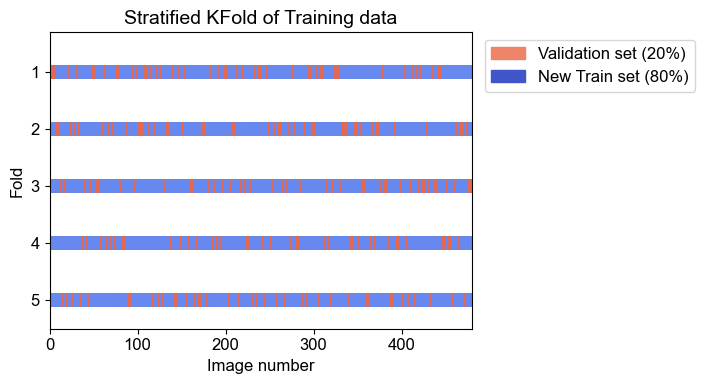

In [99]:

def plot_kfold(cv, X, y, ax, n_splits):

    """
    Plots the indices for a cross-validation object.

    Args:


        cv (StratifiedKFold): Cross-validation object.
        X (array-like): Feature data.           
        y (array-like): Target data.
        ax (matplotlib.axes.Axes): Axes object to plot on.
        n_splits (int): Number of splits in the cross-validation.

    """

    #Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)

    #List for saving proportions in training
    train_prop=[]

    for i_split, (train_idx, val_idx) in enumerate(cv_split):

        #Create an array of NaNs and fill in training/validation indices
        indices = np.full(len(X), np.nan)
        indices[val_idx], indices[train_idx] = 1, 0

        #Save proportion of images used for new training set
        train_prop.append(len(indices[train_idx])/ (len(indices[train_idx])+len(indices[val_idx])))

        #Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)

        ax.scatter(ax_x, ax_y, c=indices, marker="_",
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)

    #Set y-ticks and labels
    y_ticks = np.arange(n_splits) + 0.5

    ax.set(yticks=y_ticks, yticklabels= np.arange(1, n_splits+1),
           xlabel="Image number", ylabel="Fold",
           ylim=[n_splits, -0.2], xlim=[0, len(X)])

    #Set plot title and create legend
    ax.set_title(f"Stratified KFold of Training data", fontsize=14)
    legend_patches = [Patch(color=cmap_cv(0.8), label=f"Validation set ({100-int(np.mean(train_prop)*100)}%)"),
                      Patch(color=cmap_cv(0.02), label=f"New Train set ({int(np.mean(train_prop)*100)}%)")]
    ax.legend(handles=legend_patches, loc=(1.03, 0.8))

    #Check split proportions
    if all(i !=train_prop[0] for i in train_prop):
        print("Warning: Train/Val splits are not equal proportions across folds")
        ax.text(len(images)+5,n_splits, f"Warning: Train/Val splits are not \n equal proportions across folds: \n {str(train_prop)}")


#Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))
plot_kfold(kf, images, labels, ax, ksplit)
plt.tight_layout()
fig.subplots_adjust(right=0.6)

#Save plot
plt.savefig(savepath / f"Stratified_KFold_Splits_Vis.png")


**3.** Look at class balance across train and test data. 

In [100]:

#create dictionary of all training and test images
images = {'Train': glob.glob( str(data_path) + f"/train/*/**{img_ftype}"), 'Test':glob.glob( str(data_path) + f"/test/*/**{img_ftype}")}

#create dataframe of images and their classes
labels = []
for x in ['Train', 'Test']:
    labels.append(pd.DataFrame([[os.path.basename(os.path.dirname(i)),os.path.basename(i), x] for i in images[x]]))
labels = pd.concat(labels)
labels.columns = ['Label','Image','Split']
labels.to_csv(savepath / f"Train_Test_Splits.csv")

# #order by number of images
idx = list(labels.groupby(['Label']).count().sort_values(by="Image").index)
data = labels.groupby(['Label', 'Split']).size().unstack()
data = data.loc[idx, :]

data

Split,Test,Train
Label,,
S,11,38
X,14,64
K,18,81
AB,35,122
C,42,175


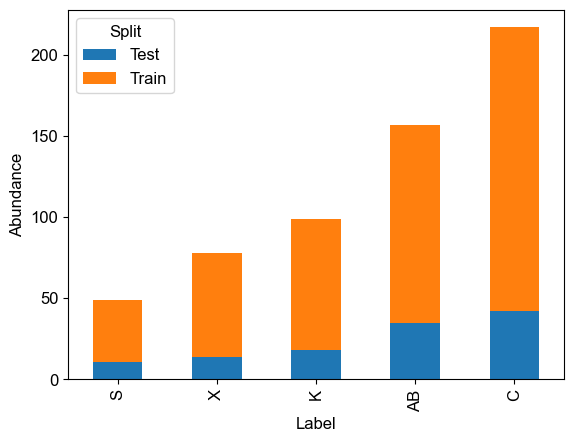

In [101]:

#plot
data.plot(kind='bar', stacked=True)
plt.ylabel('Abundance')
plt.savefig(savepath / f"Class_abundance_data_splits.png")

<mark>**Next Step:**</mark> Proceed to [4. Training & Validation](#4-training--validation) to train the model ***or*** skip to [5. Testing](#5-testing) to test the model if already completed training ***or*** skip to [6. Evaluation](#6-evaluation) to evaluate the test predictions.

## 4. Training & Validation

**1.** Download/Load YOLO modeL. 

> **Note:** The following downloads a pre-trained model which is recommended for training (Transfer learning). See commented code for other options.


In [102]:

#Load a pretrained model (recommended for training)
model = YOLO(config['model'])

#model = YOLO("saved_models/yolov8n-cls.yaml")  # build a new model from YAML
#model = YOLO("saved_models/yolov8n-cls.yaml").load("saved_models/yolov8n-cls.pt")  # build from YAML and transfer weights

# Display model information (optional)
model.info()

YOLOv8m-cls summary: 80 layers, 17,053,336 parameters, 0 gradients, 42.9 GFLOPs


(80, 17053336, 0, 42.9150208)

**2.** Train

Here you will train the YOLO model using the training data. The training process will be displayed in the output cell, showing the loss and accuracy for each epoch. However performance metrics will also be saved automatically to the project directory in a folder called 'Runs'. 

Unfortunately, YOLO does not accept a list of image names for each kfold, they must exist in a folder somewhere. Therefore the code will make a copy of the images for each kfold in a temporary folder. This will be deleted at the end of the training process.

> **Important** If you have previously completed training, you do not need to run this cell again. You can skip to [5. Testing](#5-testing) to test the model. 

In [103]:

#create dictionary for saving training results
train_results = {}
time_res = []

#get all training images
images = np.array(glob.glob(str(data_path) + f"/train/*/**{img_ftype}"))

#loop through k partitions
for k in range(ksplit):

    #init. time of kfold
    k_start = time.time()

    #extract kfold indexes for splitting data
    kfold = kfolds[k]

    #create folder of ksplit images
    k_datapath = data_path / f"temp_ksplit_{str(k+1)}"

    #get kfold dataset partitions
    train = images[kfold[0]]
    val = images[kfold[1]]

    #copy partition images to k data folder
    for set, dset in [('train', train), ('val', val)]:
        for img in tqdm(dset, desc=f"Copying {set} images for K-fold={str(k+1)}..."):
            
            #get label of image
            label = os.path.basename(os.path.dirname(img))

            #get new directory where image will be saved
            img_dir = k_datapath / set / label

            # Create the directory if it doesn't exist
            if not os.path.exists(img_dir):
                os.makedirs(img_dir)

            #copy image
            shutil.copy(img, img_dir / f"{os.path.basename(img)}")

    print("Training model on kfold: ", k+1)    

    # init. train time for kfold
    k_train_time_s  = time.time()

    # Load pre-trained model
    model = YOLO(config['model'])

    #train model on data partition
    train_results[k] = model.train(data=k_datapath, #path to images
                            epochs=int(config['epochs']), #max no. epochs
                            imgsz=config['imgsz'], #image size
                            batch=int(config['batch']), #batch size
                            device=config['device'], #gpu
                            patience=int(config['patience']), # early-stopping
                            save_period=int(config['save_period']),
                            project=savepath, #directory
                            name=f"train_{k+1}", #folder name
                            exist_ok = True, #allows overwriting of existing folder
                            plots=True, #make performance plots
                            )



    # #remove unnecessary folder
    shutil.rmtree(k_datapath)


    #get yolo speed metrics
    time_res_k =  train_results[k].speed

    #add additional time results
    time_res_k['k_time_s']= time.time() - k_start #get full time for kfold processing
    time_res_k['k_train_time_s']= time.time() - k_train_time_s   #model training
    time_res_k['kfold'] = k+1
    pd.Series(time_res_k).to_csv(savepath / f"train_{k+1}" / "time_results.csv", sep=';', index=False)


Copying train images for K-fold=1...:   0%|          | 0/384 [00:00<?, ?it/s]

KeyboardInterrupt: 

**3.** Plot Epoch loss

In [ ]:

##loop through k partitions and get epoch data
epoch_res = []

for k in range(ksplit):
     results= pd.read_csv(savepath / f"train_{k+1}" / 'results.csv')
     results.insert(len(results.columns), "kfold", [k+1]*len(results))
     epoch_res.append(results)

epoch_res = pd.concat(epoch_res)


##Plot individual losses for each k-fold
epoch_res.groupby('kfold')['train/loss'].plot(legend=True, xlabel='Epoch', ylabel='Train Loss', title='K-fold Training Loss')
plt.savefig(savepath / f"Raw_kfold_Train_Loss.png")

print('\n')

plt.figure()
epoch_res.groupby('kfold')['val/loss'].plot(legend=True, xlabel='Epoch', ylabel='Val Loss', title='K-fold Validation Loss')
plt.savefig(savepath / f"Raw_kfold_Val_Loss.png")


In [ ]:

##Plot average train/val loss over k-folds
d = epoch_res.groupby(by='epoch')
means = d.mean()
ci = confInt(d, 1.96)

plt.figure()
plt.plot(means.index, means['train/loss'], 'b-', label='Train')
plt.fill_between(means.index, means['train/loss']-ci['train/loss'], means['train/loss']+ci['train/loss'], alpha=0.5)

plt.plot(means.index, means['val/loss'], 'r-', label='Val')
plt.fill_between(means.index, means['val/loss']-ci['val/loss'], means['val/loss']+ci['val/loss'], alpha=0.5)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel(R'Mean k-fold Loss (${\pm}$ 95 CI)')
plt.savefig(savepath / f"Mean_kfold_Train_Val_Loss.png")

**4.** Run inference (get predictions) on training and val images with the **best** epoch model (to calculate performance metrics).

In [ ]:

#create dictionary for saving training results
results = {}
best_labels = []

time_res = []

#get all training images
images = np.array(glob.glob(str(data_path) + f"/train/*/**{img_ftype}"))


#loop through k partitions
for k in range(ksplit):

    #init. time of kfold
    k_start = time.time()

    #extract kfold indexes for splitting data
    kfold = kfolds[k]

    #get kfold dataset partitions
    train = images[kfold[0]]
    val = images[kfold[1]]

    k_datapath = data_path / f'temp_{str(k+1)}'

     #copy partition images to k data folder
    for set, dset in [('train', train), ('val', val)]:
        for img in tqdm(dset, desc=f"Copying {set} images for K-fold={str(k+1)}..."):

            #get label of image
            label = os.path.basename(os.path.dirname(img))

            #get new directory where image will be saved
            img_dir = k_datapath / set

            # Create the directory if it doesn't exist
            if not os.path.exists(img_dir):
                os.makedirs(img_dir)

            #copy image
            shutil.copy(img, img_dir / f"{os.path.basename(img)}")

    # init. train time for kfold
    k_train_time_s  = time.time()

    #get k training folder
    k_trainpath = savepath / f"train_{k+1}"

    project_path = "epoch_models"

    #get epoch models
    epoch_models = [model for model in os.listdir(k_trainpath / 'weights') if 'best' in model]

    for epoch_model in epoch_models:

        model = YOLO(k_trainpath / f"weights/{epoch_model}")

        for set in ['train', 'val']:

            print("Predicting on kfold: ", k+1, "set: ", set)

            # kset_datapath = k_datapath / f'{set}'

            # #run classification predictions on test set
            results[f"{k}_{set}_{epoch_model}"] = model(k_datapath / f"{set}",
                save=False, # save the images with the predictions on it
                imgsz=config['imgsz'], # set same size as in your training
                # save the results to txt files
                save_txt = True,
                save_conf = True,
                exist_ok = True, #allows overwriting of existing folder, stops creation of new folders however predictions just get added to existing txt file which is annoying....
                project= savepath / project_path ,
                name= f"predict_{k+1}_{set}_{epoch_model.split('.')[0]}") #stop inference results accumulating in RAM


            # #save the path to the detections folders
            predictions_dir = PureWindowsPath(str(model.predictor.save_dir)).as_posix()

            predictions_dir

            #get predicted labels
            filenames = os.listdir(Path(predictions_dir) / "labels")

            #save the labels (class name and numeric ID)
            labels_dict= {name:id for id, name in model.names.items()}

            #load predicted labels and get max scoring classes
            labels = []
            for f in filenames:

                try:
                    label = pd.read_csv(Path(predictions_dir) / f"labels/{f}", header=None, sep=" ")

                    #combine any class names with space in
                    if len(label.columns) > 2:
                        label.fillna('', inplace=True)
                        label.loc[:, 1] = [" ".join([l for l in label.iloc[i, 1:]]) for i in np.arange(len(label))]
                        label = label.loc[:, :1]

                    labels.append(pd.DataFrame(np.append(f.replace(".txt", f"{img_ftype}"),label.iloc[label.max().index[0]])).T)

                except:
                    print(f"Problem processing:", Path(predictions_dir) / f"labels/{f}")

            # # concat, add columns and get one-hot encoded class labels
            labels = pd.concat(labels)
            labels.columns=['image','score','label']

            #if class label is one-hot encoded (numeric) add label in semantic format
            if pd.api.types.is_numeric_dtype(labels.label):
                labels.insert(2, "class", [labels_dict[str(int(l))] for l in labels.label], True)
            else:
                labels.insert(2, "class", [labels_dict[l] for l in labels.label], True)

            #export to csv
            labels.to_csv(predictions_dir   + "/" + "labels.csv", index=False, header=True)

            labels.insert(len(labels.columns), "set", [set]*len(labels), True)
            # labels.insert(len(labels.columns), "epoch", [int((epoch_model.split('epoch')[-1]).split('.')[0])]*len(labels), True)

            labels.insert(len(labels.columns), "kfold", [k+1]*len(labels), True)

            best_labels.append(labels)

    #remove unnecessary temp test folder
    if os.path.isdir(k_datapath):
        shutil.rmtree(k_datapath)


##################

best_labels_df = pd.concat(best_labels)

images = glob.glob( str(data_path) + "/train/*/**.png")
##################################################

image_data = pd.DataFrame([images, [os.path.basename(img) for img in images]]).T
image_data.columns = ['path','image']


# get image name from path
best_labels_df= best_labels_df.merge(image_data, on='image')

#get actual labels of test set
actual = [os.path.basename(os.path.dirname(img)) for img in best_labels_df.path]

#insert actual labels into dataframe 
best_labels_df.insert(len(best_labels_df.columns), "actual", actual)

#insert epoch number into dataframe
best_labels_df.insert(len(best_labels_df.columns), "epoch", ['best']*len(best_labels_df))

#insert set number (numerical id for train/test) into dataframe
best_labels_df.insert(len(best_labels_df.columns), "set_num", [0 if i == 'train' else 1 for i in best_labels_df['set']], True)

#export to csv
best_labels_df.to_csv(savepath /project_path / 'best_labels.csv', index=False)


if os.path.exists(savepath / project_path / 'best_labels.csv') == True:
    print("Finished!")
else:
    print("Error:", savepath / project_path / 'best_labels.csv', " not saved!")



**5.** Plot confusion matrices

In [ ]:

#re-define project path in case starting from here
project_path = "epoch_models"

if os.path.exists(savepath / project_path / 'best_labels.csv') == True:
    
    #load best labels
    best_labels_df = pd.read_csv(savepath / project_path / 'best_labels.csv')

    groups = best_labels_df.groupby('set')

    for name, group in groups:


            fig, ax = plt.subplots(1,2, figsize=(10, 5), sharex=True, sharey=True)

            cmat = []
            cmat.append(ConfusionMatrixDisplay.from_predictions(group['actual'], group['label'], ax=ax[0], cmap='Blues'))
            cmat.append(ConfusionMatrixDisplay.from_predictions(group['actual'], group['label'], ax=ax[1], cmap='Blues', normalize='true'))

            for i in np.arange(2):
                ax[i].xaxis.set_ticklabels(np.unique(group['actual']), rotation=90)
                ax[i].yaxis.set_ticklabels(np.unique(group['actual']))
                # plt.title(f'Sum of kfolds')

                # Remove axis lines while keeping the ticks and labels
                ax[i].spines['top'].set_visible(False)
                ax[i].spines['right'].set_visible(False)
                ax[i].spines['left'].set_visible(False)
                ax[i].spines['bottom'].set_visible(False)


                # Remove the border (spines) of the colorbar
                cbar = cmat[i].im_.colorbar
                cbar.outline.set_visible(False)
                if i ==1:
                    cbar.set_ticks(np.linspace(0,1,6))

            plt.suptitle(name)
            plt.savefig(savepath / f"{name}_Confusion_Matrix_Summed_K-folds_Norm.png")

            print('\n')
else:
    print(f"Error: Cannot load best_labels.csv. Check file path: {project_path / 'best_labels.csv'}.")

<mark>**Next Step:**</mark> Proceed to [5. Testing](#5-testing) to test the model. Section [4.1 Epoch Inference](#41-epoch-inference-optional) is optional and not recommended to run in Colab (without some adjustments) as it may crash the session. 

### 4.1 Epoch Inference **(Optional!)**

This section is ***not necessary***, but can provide more info on epoch performance in training and validation splits. It will run predictions for each epoch model that was exported. 

Currently, no interim epoch models are exported as this requires more storage space (~90.5 MB for each epoch model weights file you export). Only the best and last models are exported.

Should you wish to explore performance more thoroughly over epochs, you can adjust the **save_period** in the training .json file ([Section 3.1.2](#312-load--update)). 

For example: 

- **3** = save the model weights every 3 epochs
- **-1** = disable epoch saving (default) 

> **Warning:** Epoch inference takes a while and may cause the session to crash due to the large number of computations. It is not recommended to run this in Colab. Unless you limit the number of epoch models to explore or do less k-folds for example. 

**1.** Run Inference on all epoch models (includes best again, ignores last)

In [ ]:

# # Markdown text
markdown_text = f"""

This section is not necessary but can provide more info into epoch performance in training and validation splits.


**Warning:** It will take some time to train and is not recommended in Colab as it may crash as it requires quite a lot of computations!

    """

# # Display the Markdown
print(markdown_text)


# Create widgets

# Run button
run_button = widgets.Button(
    description="Run Epoch Inference",
    button_style='success',
    disabled=False  # Start disabled until mode is selected
)


# output widget for button
button_output = widgets.Output()

#display widgets
display(run_button, button_output)


# Handle Run button click
def on_run_button_click(b):
      
      """ Handle the Run button click event. 
        Args:
            b: The button click event.
        Returns:
            None: The function runs the inference process."""
      
      with button_output:


        #create dictionary/lists for saving training results
        results = {}
        all_labels = []
        time_res = []

        #get all training images
        images = np.array(glob.glob(str(data_path) + f"/train/*/**{img_ftype}"))

        #loop through k partitions
        for k in range(ksplit):

            #init. time of kfold
            k_start = time.time()

            #extract kfold indexes for splitting data
            kfold = kfolds[k]

            #get kfold dataset partitions
            train = images[kfold[0]]
            val = images[kfold[1]]

            #set path to temporary data folder for kset
            k_datapath = data_path / 'temp_{str(k+1)}'

            #get k training folder
            k_trainpath = savepath / f"train_{k+1}"
            project_path =  "epoch_models"

            #get epoch models
            epoch_models = [model for model in os.listdir(k_trainpath / 'weights') if 'last' not in model]


            #only run if interim epoch models present
            if len([model for model in epoch_models if 'best' not in model]) > 0:                    

                #copy partition images to k data folder
              for set, dset in [('train', train), ('val', val)]:
                  for img in tqdm(dset, desc=f"Copying {set} images for K-fold={str(k+1)}..."):                              

                      #get label of image
                      label = os.path.basename(os.path.dirname(img))

                      #get new directory where image will be saved
                      img_dir = k_datapath / set

                      # Create the directory if it doesn't exist
                      if not os.path.exists(img_dir):
                          os.makedirs(img_dir)

                      #copy image
                      shutil.copy(img, img_dir / f"{os.path.basename(img)}")

              # init. train time for kfold
              k_train_time_s  = time.time()             

              # Run Inference             
              for epoch_model in epoch_models:


                  model = YOLO(k_trainpath / f"weights/{epoch_model}")

                  for set in ['train', 'val']:

                      print("Predicting with epoch model: ", epoch_model, "on kfold: ", k+1, "set: ", set)

                      predictions_dir = savepath / project_path / f"predict_{k+1}_{set}_{epoch_model.split('.')[0]}"

                      print(predictions_dir)

                      if os.path.exists(predictions_dir) == False:

                          # kset_datapath = k_datapath / f'{set}'
                          try:
                              # #run classification predictions on set
                              results[f"{k}_{set}_{epoch_model}"] = model(k_datapath / f"{set}",
                                  save=False, # save the images with the predictions on it
                                  imgsz=config['imgsz'], # set same size as in your training
                                  # save the results to txt files
                                  save_txt = True,
                                  save_conf = True,
                                  exist_ok = True, #allows overwriting of existing folder, stops creation of new folders however predictions just get added to existing txt file which is annoying....
                                  project= savepath / project_path,
                                  name=  f"predict_{k+1}_{set}_{epoch_model.split('.')[0]}") #stop inference results accumulating in RAM

                          except:
                              print(f"Problem processing: {predictions_dir}")

                              #remove incase partially processed
                              if os.path.isdir(predictions_dir):
                                  shutil.rmtree(predictions_dir)

                      # #save the path to the detections folders
                      # predictions_dir = PureWindowsPath(str(model.predictor.save_dir)).as_posix()


                      #get predicted labels
                      filenames = os.listdir(Path(predictions_dir) / "labels")

                      #save the labels (class name and numeric ID)
                      labels_dict= {name:id for id, name in model.names.items()}

                      #load predicted labels and get max scoring classes
                      labels = []
                      for f in filenames:

                          try:
                              label = pd.read_csv(Path(predictions_dir) / f"labels/{f}", header=None, sep=" ")

                              #combine any class names with space in
                              if len(label.columns) > 2:
                                  label.fillna('', inplace=True)
                                  label.loc[:, 1] = [" ".join([l for l in label.iloc[i, 1:]]) for i in np.arange(len(label))]
                                  label = label.loc[:, :1]

                              labels.append(pd.DataFrame(np.append(f.replace(".txt", f"{img_ftype}"),label.iloc[label.max().index[0]])).T)

                          except:
                              print(f"Problem processing:", Path(predictions_dir) / f"labels/{f}")

                      # # concat, add columns and get one-hot encoded class labels
                      labels = pd.concat(labels)
                      labels.columns=['image','score','label']

                      #if class label is one-hot encoded (numeric) add label in semantic format
                      if pd.api.types.is_numeric_dtype(labels.label):
                          labels.insert(2, "class", [labels_dict[str(int(l))] for l in labels.label], True)
                      else:
                          labels.insert(2, "class", [labels_dict[l] for l in labels.label], True)

                      #export to csv
                      labels.to_csv(predictions_dir  / "labels.csv", index=False, header=True)

                      labels.insert(len(labels.columns), "set", [set]*len(labels), True)

                      labels.insert(len(labels.columns), "epoch", [(epoch_model.split('epoch')[-1]).split('.')[0]]*len(labels), True)

                      labels.insert(len(labels.columns), "kfold", [k+1]*len(labels), True)

                      all_labels.append(labels)

            else:
              print("Error: No interim epoch models found in: ", k_trainpath, ". Models found: ", epoch_models)

            #remove unnecessary temp test folder
            if os.path.isdir(k_datapath):
                shutil.rmtree(k_datapath)


            ##################
            if len(all_labels) >0:
                #convert to dataframe
                all_labels_df = pd.concat(all_labels)

                #get image paths
                image_data = pd.DataFrame([images, [os.path.basename(img) for img in images]]).T
                image_data.columns = ['path','image']

                #merge with dataframe
                all_labels_df= all_labels_df.merge(image_data, on='image')

                #get actual labels
                actual = [os.path.basename(os.path.dirname(img)) for img in all_labels_df.path]

                #add columns to data frame
                all_labels_df.insert(len(all_labels_df.columns), "actual", actual)
                all_labels_df.insert(len(all_labels_df.columns), "set_num", [0 if i == 'train' else 1 for i in all_labels_df['set']], True)


                # #separate best epoch results
                best_labels_df = all_labels_df[all_labels_df.epoch == 'best']
                all_labels_df = all_labels_df[all_labels_df.epoch != 'best'] # keep only numbered epochs as best epochs may be repeated i.e. if best epoch = epoch 3, we would have duplicates of epoch 3.


                # #export to csv
                all_labels_df.to_csv(savepath / project_path / 'labels.csv', index=False)
                best_labels_df.to_csv(savepath / project_path/ 'best_labels.csv', index=False)
                
                if os.path.exists(savepath / project_path / 'labels.csv') == False:
                    print("Error:", savepath / project_path / 'labels.csv', " not saved!")   


                if os.path.exists(savepath / project_path / 'best_labels.csv') == False:
                    print("Error:", savepath / project_path / 'best_labels.csv', " not saved!")
        
                
                print("Finished!")



# observe widgets
run_button.on_click(on_run_button_click)




**2.** Plotting Epoch Performance

This is only relevant if you ran: [Training & Validation Epoch Inference](#training-and-validation-epoch-inference-optional)

In [ ]:

# Set project path if missing
# project_path = 'epoch_models' 

#set default
make_epoch_plots = True

if os.path.exists(savepath / project_path / 'labels.csv'):
  all_labels_df = pd.read_csv(savepath / project_path / 'labels.csv')
  all_labels_df.epoch = all_labels_df.epoch.astype(int)

elif os.path.exists(savepath / project_path / 'best_labels.csv'):
  all_labels_df = pd.read_csv(savepath / project_path / 'best_labels.csv')
  print("No epoch data to plot, using best labels instead")
  # all_labels_df.insert(len(all_labels_df.columns), "epoch", ['best']*len(all_labels_df))
else:
  make_epoch_plots = False


if make_epoch_plots == True:
  #sep train and val data
  train = all_labels_df[all_labels_df.set == 'train']
  val = all_labels_df[all_labels_df.set == 'val']


  plt.figure()

  colours = ['b', 'r', 'yellowgreen']
  b_patch = Patch(color=colours[0], label='Train')
  r_patch = Patch(color=colours[1], label='Val')
  g_patch = Patch(color=colours[2], label='Acc')



  colours= {'train':'b', 'val':'r', 'acc':'yellowgreen'}

  for set, dset in [('train', train), ('val', val)]:
      sub=dset[['epoch','score']]

      d = sub.groupby(by='epoch')
      means = d.mean()
      ci = confInt(d, 1.96)

      means = means.astype(float)
      ci = ci.astype(float)

      if len(means) >1:
        plt.plot(means.index, means['score'], color = colours[set], label=set)
        plt.fill_between(means.index,means['score']-ci['score'], means['score']+ci['score'], alpha=0.5,color = colours[set])

      else:
        plt.errorbar(means.index, means['score'], yerr=ci['score'], fmt='o', color=colours[set],
              ecolor=colours[set], elinewidth=3, capsize=0, alpha=0.5)



  plt.legend(handles=[b_patch,r_patch])
  plt.xlabel('Epoch')
  plt.ylabel(R'Mean Score (${\pm}$ 95 CI)')
  plt.title('Model Confidence in Prediction')
  plt.savefig(savepath / project_path / f"mean_model_conf_in_pred.png")

else:
  print(f"No epoch data to plot. Missing {savepath / project_path / 'labels.csv'} and {savepath / project_path / 'best_labels.csv'}")


In [ ]:
if make_epoch_plots == True:
    plt.figure()
    for set, dset in [('train', train), ('val', val)]:
        plt.scatter(dset['epoch'], dset['score'], color = colours[set], label=set)
    plt.legend(handles=[b_patch,r_patch])
    plt.xlabel('Epoch')
    plt.ylabel(R'Score')
    plt.title('Model Confidence in Prediction')
    plt.savefig(savepath / project_path / f"model_conf_in_pred_scatter.png")
else:
  print(f"No epoch data to plot. Missing {savepath / project_path / 'labels.csv'} and {savepath / project_path / 'best_labels.csv'}")


In [ ]:
if make_epoch_plots == True:
  groups = all_labels_df.groupby('label')

  fig, axs = plt.subplots(1,5, figsize=(15,4))

  count = 0
  for name, group in groups:
      
      #get train and val data
      train = group[group.set == 'train']
      val = group[group.set == 'val']


      for set, dset in [('train', train), ('val', val)]:
          #get data for plotting
          sub=dset[['epoch','score']]

          #get summary stats
          d = sub.groupby(by='epoch')
          means = d.mean()
          ci = confInt(d, 1.96)

          means = means.astype(float)
          ci = ci.astype(float)

          #plot data
          if len(means) >1:
            axs[count].plot(means.index, means['score'], color = colours[set], label=set)

            axs[count].fill_between(means.index,means['score']-ci['score'], means['score']+ci['score'], alpha=0.5,color = colours[set])
          else:
            axs[count].errorbar(means.index, means['score'], yerr=ci['score'], fmt='o', color=colours[set],
              ecolor=colours[set], elinewidth=3, capsize=0, alpha=0.5)

          axs[count].set_xlabel('Epoch')
          axs[count].set_title(name)
          # axs[count].set_xticks(np.linspace(0,30,7),np.linspace(0,30,7))


      count += 1

  plt.suptitle('Model Confidence in Prediction')
  axs[0].set_ylabel(R'Mean Score (${\pm}$ 95 CI)')

  plt.savefig(savepath / project_path / f"mean_model_conf_in_pred_classes.png")

  # axs[0,count].legend(handles=[b_patch,r_patch])
else:
  print(f"No epoch data to plot. Missing {savepath / project_path / 'labels.csv'} and {savepath / project_path / 'best_labels.csv'}")


**3.** Calculate Training & Val performance metrics for each epoch model

In [ ]:

if make_epoch_plots == True:
    
    #sep train and val data
    train = all_labels_df[all_labels_df.set == 'train']
    val = all_labels_df[all_labels_df.set == 'val']


    acc = []
    clf_results = []

    for set, dset in [(f'train', train), (f'val', val)]:

        groups = dset.groupby(['epoch'])

        for group in groups:

            g = group[0]
            data = group[1]

            # # calculate accuracy
            acc.append([accuracy_score(data['actual'], data['label']), g[0], set])


            #get clf report
            clf_res = classification_report(data['actual'], data['label'], output_dict=True)
            clf_res = pd.DataFrame(clf_res).transpose().reset_index()
            clf_res.insert(len(clf_res.columns),"epoch", [g[0]]*len(clf_res))
            clf_res.insert(len(clf_res.columns),"set", [set]*len(clf_res))
            clf_res.columns = ["label"]+[c for c in clf_res.columns[1:]]
            clf_results.append(clf_res)

    #convert to dataframe
    acc = pd.DataFrame(acc, columns= ['accuracy', 'epoch', 'set'])

    #get classification report
    clf_results = pd.concat(clf_results)
    clf_results.reset_index(inplace=True, drop=True)

    #convert to dataframe
    df = clf_results.loc[[i for i in clf_results.index if clf_results.loc[i, 'label'] not in ['accuracy', 'macro avg', 'weighted avg']],:]

    #set label as categorical
    df.label = df.label.astype("category")

else:
  print(f"No epoch data to plot. Missing {savepath / project_path / 'labels.csv'} and {savepath / project_path / 'best_labels.csv'}")


In [ ]:

if make_epoch_plots == True:

  #sep train and val data
  train = all_labels_df[all_labels_df.set == 'train']
  val = all_labels_df[all_labels_df.set == 'val']


  acc = []
  clf_results = []

  for set, dset in [(f'train', train), (f'val', val)]:

      groups = dset.groupby(['epoch', 'kfold'])  # include kfold in grouping

      for (epoch, kfold), data in groups:

          #get accuracy
          accuracy = accuracy_score(data['actual'], data['label'])

          #add to accuracy list
          acc.append([accuracy, epoch, kfold, set])


          # Get classification report
          clf_res = classification_report(data['actual'], data['label'], output_dict=True)
          #convert to dataframe and reset index

          clf_res = pd.DataFrame(clf_res).transpose().reset_index()

          #insert epoch, kfold and set into dataframe
          clf_res.insert(len(clf_res.columns), "epoch", [epoch] * len(clf_res))
          clf_res.insert(len(clf_res.columns), "kfold", [kfold] * len(clf_res))
          clf_res.insert(len(clf_res.columns), "set", [set] * len(clf_res))

          #reorder columns
          clf_res.columns = ["label"] + [c for c in clf_res.columns[1:]]

          #append to results list
          clf_results.append(clf_res)

  # Convert accuracy results to DataFrame
  acc_df = pd.DataFrame(acc, columns=['accuracy', 'epoch', 'kfold', 'set'])

  # Prepare clf_results DataFrame
  clf_results = pd.concat(clf_results).reset_index(drop=True)


  # Filter classification results to remove unwanted labels
  df = clf_results.loc[[i for i in clf_results.index if clf_results.loc[i, 'label'] not in ['accuracy', 'macro avg', 'weighted avg']],:]

  # Set label as categorical
  df.label = df.label.astype("category")

else:
  print(f"No epoch data to plot. Missing {savepath / project_path / 'labels.csv'} and {savepath / project_path / 'best_labels.csv'}")




In [ ]:
if make_epoch_plots == True:
  ##Plot average train/val loss over k-folds

  colours = ['b', 'r']

  for i, set in enumerate(['train', 'val']):
      #get data for plotting
      acc_sub = acc_df[acc_df.set == set]

      # group
      d = acc_sub.groupby(by=['epoch'])

      # get accuracy
      d = d['accuracy']

      #get summary stats
      means = d.mean()
      ci = confInt(d, 1.96)

      if len(means) >1:
        plt.plot(means.index, means, 'r-', label=set, color=colours[i])
        plt.fill_between(means.index, means-ci, means+ci, alpha=0.5)

      else:

        plt.errorbar(means.index, means, yerr=ci, fmt='o', color=colours[i],
                    ecolor=colours[i], elinewidth=3, capsize=0, alpha=0.5)


      plt.legend()
      plt.xlabel('Epoch')
      plt.ylabel(R'Mean k-fold accuracy (${\pm}$ 95 CI)')

  plt.savefig(savepath / project_path / f"accuracy.png")

else:
  print(f"No epoch data to plot. Missing {savepath / project_path / 'labels.csv'} and {savepath / project_path / 'best_labels.csv'}")



In [ ]:
if make_epoch_plots == True:

    #sep train and val data
    train = df[df.set == 'train']
    val = df[df.set == 'val']


    fig, axes = plt.subplots(3,2, figsize=(10,10), sharey=True, sharex=True)

    train.plot.scatter(x='epoch', y='precision', c='label', colormap='viridis', s='support', title='Train',ax=axes[0,0])
    val.plot.scatter(x='epoch', y='precision', c='label', colormap='viridis', s='support', title='Val',ax=axes[0,1])

    train.plot.scatter(x='epoch', y='recall', c='label', colormap='viridis', s='support', title='Train',ax=axes[1,0])
    val.plot.scatter(x='epoch', y='recall', c='label', colormap='viridis', s='support', title='Val',ax=axes[1,1])

    train.plot.scatter(x='epoch', y='f1-score', c='label', colormap='viridis', s='support', title='Train',ax=axes[2,0])
    val.plot.scatter(x='epoch', y='f1-score', c='label', colormap='viridis', s='support', title='Val',ax=axes[2,1])



    plt.savefig(savepath / project_path / f"class_metrics.png")



    # counts
    print('train')

    #get groups
    groups = train.groupby('label')

    #print mean support for each class
    for name, group in groups:

        print(name, '=', int(np.mean(group.support)))

    print('\n')

    print('val')
    
    groups = val.groupby('label')
    
    #print mean support for each class
    for name, group in groups:

        print(name, '=', int(np.mean(group.support)))
else:
  print(f"No epoch data to plot. Missing {savepath / project_path / 'labels.csv'} and {savepath / project_path / 'best_labels.csv'}")


<mark>**Next Step:**</mark> Proceed to [5. Testing](#5-testing) to test the model.

## 5. Testing

**1.** Run inference on test images with the **best** epoch model (to calculate performance metrics). 

In [ ]:

#get test images
images = glob.glob( str(data_path) + f"/test/*/**{img_ftype}")

#create temporary directory name
test_datapath = data_path / "temp"

#create the temp test directory if it doesn't exist
if not os.path.exists(test_datapath):
    os.makedirs(test_datapath)

#copy test images to new temporary folder
for image in images:
    shutil.copy(image, data_path / "temp" / f"{os.path.basename(image)}")


#create dictionary for saving testing results
test_results = {}
time_res = []

#loop through k partitions
for k in np.arange(ksplit):

    #init. time of kfold
    k_start = time.time()

    #get k training folder
    k_trainpath = savepath / f"train_{k+1}"

    # init. test time for kfold
    k_test_time_s  = time.time()

    # Load trained model
    model = YOLO(k_trainpath / "weights/best.pt")

    #YOLO overwrite mode appends new predictions to existing label .txt file, remove these files to stop this.
    if os.path.exists(savepath / f"predict_{k+1}" / "labels"):
        shutil.rmtree(savepath / f"predict_{k+1}" / "labels")

    
    print("Predicting on kfold: ", k+1)

    # #run classification predictions on test set
    test_results[k] = model(test_datapath,
        save=False, # save the images with the predictions on it
        imgsz=config['imgsz'], # set same size as in your training
        # save the results to txt files
        save_txt = True,
        save_conf = True,
        exist_ok = True, #allows overwriting of existing folder, stops creation of new folders however predictions just get added to existing txt file which is annoying....
        project= savepath,
        name= f"predict_{k+1}") #stop inference results accumulating in RAM


    # Capture the current time once to avoid slight mismatches
    current_time = time.time()

    # Ensure values are wrapped in lists to be columnar data
    time_res_k = pd.DataFrame.from_dict({
        'k_time_s': [current_time - k_start],
        'k_test_time_s': [current_time - k_test_time_s],
        'kfold': [k + 1]
    })

    # time_res_k['k_time_s']= time.time() - k_start #get full time for kfold processing
    # time_res_k['k_test_time_s']= time.time() - k_test_time_s   #model training
    # time_res_k['kfold'] = k+1
    time_res_k.to_csv(savepath / f"predict_{k+1}" / "time_results.csv", sep=';', index=False)

    #save the path to the detections folders
    predictions_dir = PureWindowsPath(str(model.predictor.save_dir)).as_posix()

    predictions_dir

    #get predicted labels
    filenames = os.listdir(Path(predictions_dir) / "labels")

    #save the labels (class name and numeric ID)
    labels_dict= {name:id for id, name in model.names.items()}

    #load predicted labels and get max scoring classes
    labels = []
    for f in filenames:

        try:
            label = pd.read_csv(Path(predictions_dir) / f"labels/{f}", header=None, sep=" ")

            #combine any class names with space in
            if len(label.columns) > 2:
                label.fillna('', inplace=True)
                label.loc[:, 1] = [" ".join([l for l in label.iloc[i, 1:]]) for i in np.arange(len(label))]
                label = label.loc[:, :1]

            #get max scoring class
            labels.append(pd.DataFrame(np.append(f.replace(".txt", f"{img_ftype}"),label.iloc[label.max().index[0]])).T)

        except:
            print(f"Problem processing:", Path(predictions_dir) / f"labels/{f}")

    # # concat, add columns and get one-hot encoded class labels
    labels = pd.concat(labels)
    labels.columns=['image','score','label']

    #if class label is one-hot encoded (numeric) add label in semantic format
    if pd.api.types.is_numeric_dtype(labels.label):
        labels.insert(2, "class", [labels_dict[str(int(l))] for l in labels.label], True)
    else:
        labels.insert(2, "class", [labels_dict[l] for l in labels.label], True)

    #export to csv
    labels.to_csv(predictions_dir   + "/" + "labels.csv", index=False, header=True)

    #check if running in colab. Not relevant if running in jupyter notebook for example
    # if "google.colab" in sys.modules:

    #   # Copy the entire folder
    #   shutil.copytree(f"/content/{predictions_dir}", f"/content/drive/MyDrive/{predictions_dir}")


#remove unnecessary temp test folder
if os.path.isdir(test_datapath):
    shutil.rmtree(test_datapath)


print("Finished!")


Predicting on kfold:  1

image 1/120 c:\Users\chgam8840\OneDrive - University of Bergen\Repos\D1_ImgClf\shulz_bank\data\class_images\temp\Cropped_ROV_12-2017_00006.png: 256x256 AB 1.00, K 0.00, X 0.00, C 0.00, S 0.00, 113.8ms
image 2/120 c:\Users\chgam8840\OneDrive - University of Bergen\Repos\D1_ImgClf\shulz_bank\data\class_images\temp\Cropped_ROV_12-2017_00029.png: 256x256 AB 1.00, C 0.00, X 0.00, K 0.00, S 0.00, 41.7ms
image 3/120 c:\Users\chgam8840\OneDrive - University of Bergen\Repos\D1_ImgClf\shulz_bank\data\class_images\temp\Cropped_ROV_12-2017_00037.png: 256x256 AB 1.00, C 0.00, X 0.00, K 0.00, S 0.00, 45.2ms
image 4/120 c:\Users\chgam8840\OneDrive - University of Bergen\Repos\D1_ImgClf\shulz_bank\data\class_images\temp\Cropped_ROV_12-2017_00039.png: 256x256 AB 1.00, K 0.00, X 0.00, C 0.00, S 0.00, 45.3ms
image 5/120 c:\Users\chgam8840\OneDrive - University of Bergen\Repos\D1_ImgClf\shulz_bank\data\class_images\temp\Cropped_ROV_12-2017_00066.png: 256x256 AB 1.00, X 0.00, K 0.0

<mark>**Next Step:**</mark> Proceed to [6. Evaluation](#6-evaluation) to evaluate the test predictions.

## 6. Evaluation

In this section, we will evaluate the performance of the model on the test dataset using various metrics. This includes calculating the accuracy, precision, recall, and F1 score for each class. We will also plot the confusion matrix to visualize the performance of the model.

**1.** Merge predictions for each kfold into one dataframe

In [ ]:

#get test images
images = glob.glob( str(data_path) + "/test/*/**.png")

image_data = pd.DataFrame([images, [os.path.basename(img) for img in images]]).T
image_data.columns = ['path','image']

#combine predicted and ground-truth annotations
labs = []
#loop through k partitions
for k in np.arange(ksplit):

    #get k training folder
    k_predictpath = savepath / f"predict_{k+1}"

    #get predicted labels
    l = pd.read_csv(k_predictpath   / "labels.csv",  header=0)

    #get actual labels of test set
    l= l.merge(image_data, on='image')
    actual = [os.path.basename(os.path.dirname(img)) for img in l.path]

    #insert columns
    l.insert(len(l.columns), "actual", actual)
    l.insert(len(l.columns), "kfold", [k+1]*len(l))
    labs.append(l)

#create dataframe
labels = pd.concat(labs)

#export
labels.to_csv(savepath / 'test_labels.csv', index=False)

#order by number of images
idx = list(labels.groupby(['label']).count().sort_values(by="image").index)

#sort order
data = labels.groupby(['label', 'kfold']).size().unstack()
data = data.loc[idx, :]



### 6.1 Model predictions

<Figure size 640x480 with 0 Axes>

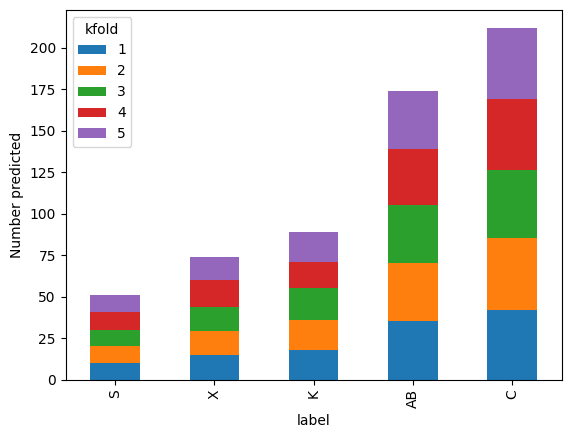

In [ ]:
#plot predictions
fig = plt.figure()
data.plot(kind='bar', stacked=True)
plt.ylabel('Number predicted')
plt.savefig(savepath / f"Number_predictions_per_class_per_fold_stakedbar.png")

### 6.2 Model confidence

In [ ]:
#get summary stats
d = labels.groupby(['label'])['score']
means = d.mean()
ci = confInt(d, 1.96)
std = d.std()
#reorder
means = means[idx]
ci = ci[idx]
std = std[idx]

print(f"Mean confidence overall = {np.round(labels.score.mean(),2)} "+'\u00B1 '+f"{np.round(confInt(labels.score, 1.96),3)}")

confidence = [means, ci,std]

Mean confidence overall = 0.98 ± 0.006


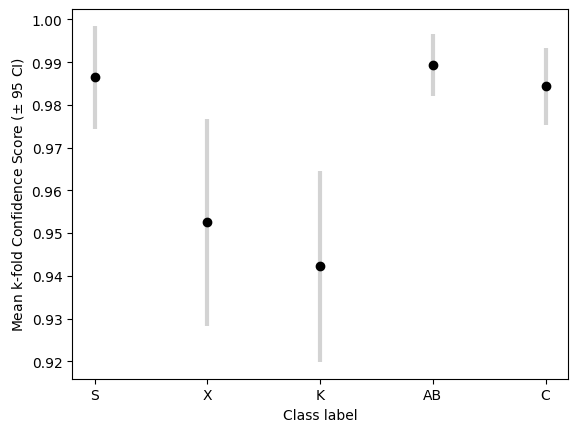

In [ ]:
#plot
plt.errorbar(means.index, means, yerr=ci, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0)
plt.xlabel('Class label')
plt.ylabel(R'Mean k-fold Confidence Score (${\pm}$ 95 CI)')
# plt.title("Class Prediction confidence (classes ordered by increasing number of images)")
plt.savefig(savepath / f"Prediction_confidence_vs_num_images_per_class.png")


### 6.3 Model accuracy

In [ ]:

acc = []
clf_results = []

groups = labels.groupby(['kfold'])
for group in groups:

    #get data 
    g = group[0]
    data = group[1]

    # # calculate accuracy
    acc.append([accuracy_score(data['actual'], data['label']), g[0]])


    #get clf report
    clf_res = classification_report(data['actual'], data['label'], output_dict=True)

    #convert to dataframe and reset index
    clf_res = pd.DataFrame(clf_res).transpose().reset_index()

    #add kfold
    clf_res.insert(len(clf_res.columns),"kfold", [g[0]]*len(clf_res))

    #sort columns
    clf_res.columns = ["label"]+[c for c in clf_res.columns[1:]]

    #add to results list
    clf_results.append(clf_res)


#convert to dataframe
acc = pd.DataFrame(acc, columns= ['accuracy', 'kfold'])

# Prepare clf_results DataFrame
clf_results = pd.concat(clf_results)

#show
clf_res

#get summary stats
d = acc.accuracy
m = np.round(d.mean(),2)
ci = confInt(d, 1.96)


print(f"Mean accuracy = {m} "+'\u00B1 '+f"{np.round(ci,3)}")



Mean accuracy = 0.98 ± 0.008


### 6.4 Class metrics

**1.** Prepare data

In [ ]:
#prepare dataframe
df = clf_results.loc[[i for i in clf_results.index if clf_results.loc[i, 'label'].iloc[0] not in ['accuracy', 'macro avg', 'weighted avg']],:]
df.label = df.label.astype("category")


**2.** Plot Precision v. Recall

In [ ]:

#plot
# df.plot.scatter(x='precision', y='recall', c='label', colormap='viridis', s='support')

# import plotly.express as px
fig = px.scatter(df, x='precision', y='recall', color='label', size='support', hover_data=['kfold'])
fig.show()


**3.** Calculate class-averaged performance

Class-averaged precision =  0.98 ± 0.006
Class-averaged recall =  0.97 ± 0.007
Class-averaged f1-score =  0.97 ± 0.005


Text(0, 0.5, 'Mean k-fold Score (${\\pm}$ 95 CI)')

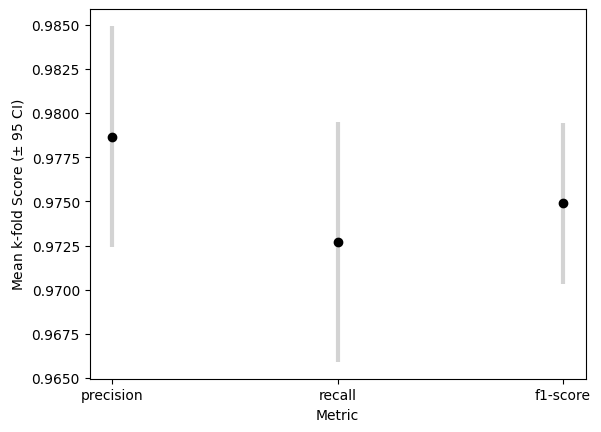

In [ ]:
#get summary stats
d =  df.loc[:,['precision', 'recall', 'f1-score']]
means = d.mean()
ci = confInt(d, 1.96)


for i, metric in enumerate(['precision', 'recall', 'f1-score']):
    print(f"Class-averaged {metric} =  {round(means[metric],2)} "+'\u00B1 '+f"{np.round(ci[metric],3)}")

#plot
plt.errorbar(means.index, means, yerr=ci, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0)
plt.xlabel('Metric')
plt.ylabel(R'Mean k-fold Score (${\pm}$ 95 CI)')


**4.** Class performance

In [ ]:
#get summary stats
means = clf_results.groupby(["label"]).mean()
std = clf_results.groupby(["label"]).std()
ns = np.sqrt(clf_results.groupby(["label"]).count())
ci = 1.96 * (std / ns)

#sort order
idx = list(means['support'].sort_values().index)
idx = [i for i in idx if i in np.unique(labels.actual)]

#sort orders
means = means.loc[idx, ['precision', 'recall', 'f1-score']]
ci = ci.loc[idx, ['precision', 'recall', 'f1-score']]
std= std.loc[idx, ['precision', 'recall', 'f1-score']]

means = means.loc[idx,:]
ci = ci.loc[idx,:]
std = std.loc[idx,:]
# list(np.unique(labels['actual']))


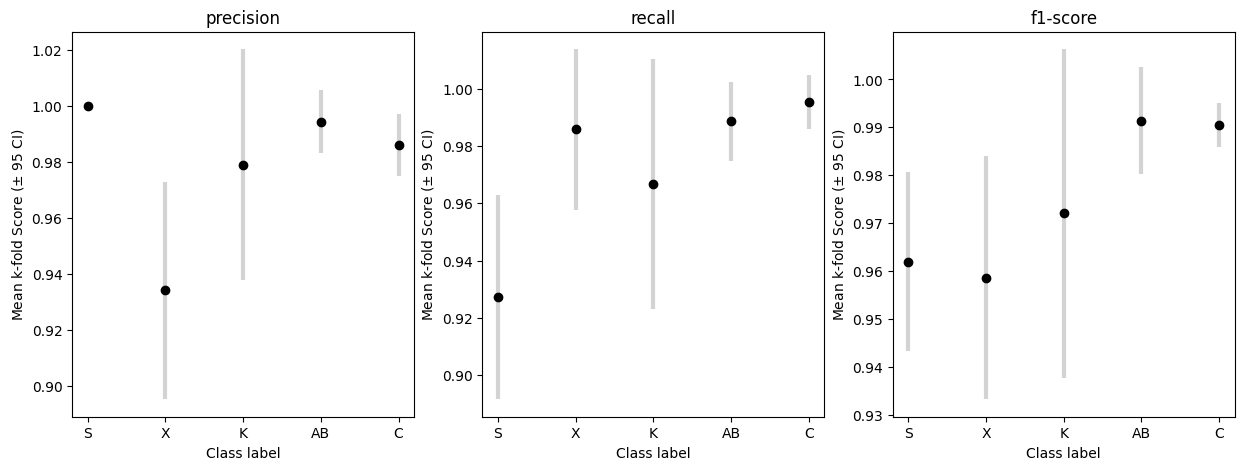

In [ ]:
#plot
fig, ax = plt.subplots(1,3,figsize=(15,5))

for i, m in enumerate(['precision', 'recall', 'f1-score']):


    ax[i].errorbar(means.index, means[m], yerr=ci[m], fmt='o', color='black',
                ecolor='lightgray', elinewidth=3, capsize=0)
    ax[i].set_title(m)
    ax[i].set_ylabel(r"Mean k-fold Score (${\pm}$ 95 CI)")
    ax[i].set_xlabel("Class label")
    # ax[i].set_xticklabels(means.index,rotation=90)
    # ax[i].set_yticks(np.linspace(0.75,1,6))
    # ax[i].set_ylim(0.75, 1.05)
    #ax[i].set_yticks(np.linspace(0.90,1,6))
    #ax[i].set_ylim(0.90-0.025, 1.025)
    # plt.suptitle("Class Test Metrics (classes ordered by increasing number of images)")

plt.savefig(savepath / f"Test_metrics_per_class1.png")
# plt.savefig(savepath / f"Test_metrics_per_class.eps")

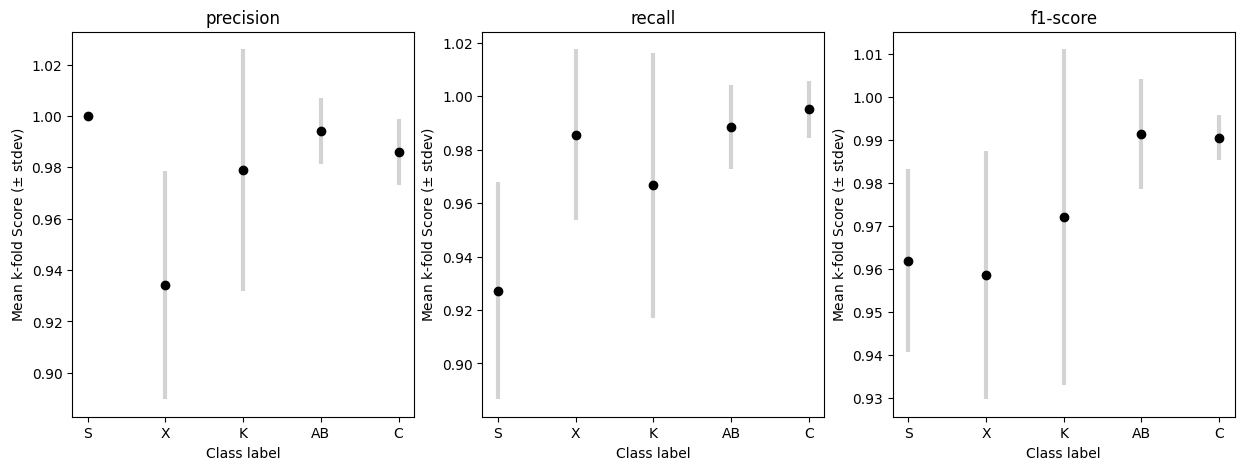

In [ ]:
#Alternative plot with STDEV error bars

fig, ax = plt.subplots(1,3,figsize=(15,5))

for i, m in enumerate(['precision', 'recall', 'f1-score']):


    ax[i].errorbar(means.index, means[m], yerr=std[m], fmt='o', color='black',
                ecolor='lightgray', elinewidth=3, capsize=0)
    ax[i].set_title(m)
    ax[i].set_ylabel(r"Mean k-fold Score (${\pm}$ stdev)")
    ax[i].set_xlabel("Class label")
    # ax[i].set_xticklabels(means.index,rotation=90)
    # ax[i].set_yticks(np.linspace(0.75,1,6))
    # ax[i].set_ylim(0.75, 1.05)
    #ax[i].set_yticks(np.linspace(0.90,1,6))
    #ax[i].set_ylim(0.90-0.025, 1.025)
    # plt.suptitle("Class Test Metrics (classes ordered by increasing number of images)")



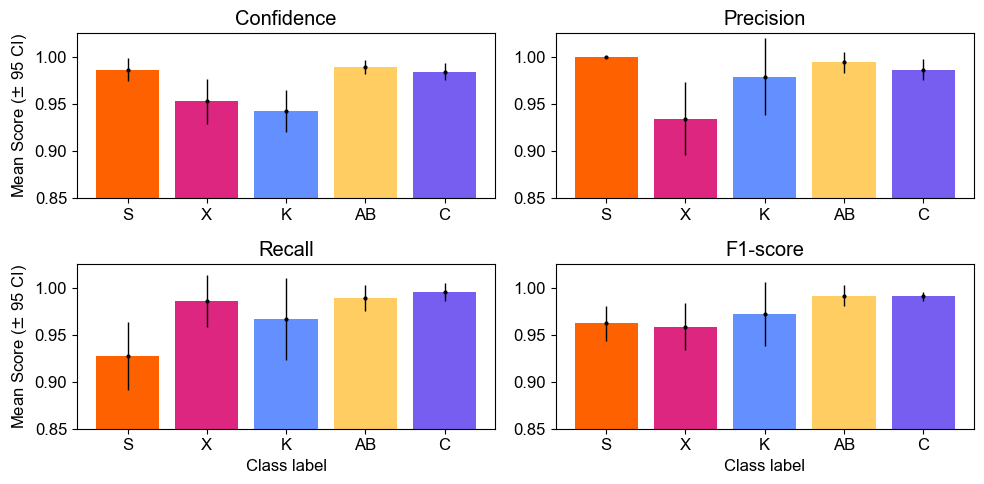

In [ ]:
means = pd.merge(means, pd.DataFrame(confidence[0]), left_index=True, right_index=True)
means.columns= ['precision', 'recall', 'f1-score', 'confidence']

ci = pd.merge(ci, pd.DataFrame(confidence[1]), left_index=True, right_index=True)
ci.columns= ['precision', 'recall', 'f1-score', 'confidence']



# Set font properties
plt.rcParams['font.family'] = 'Arial'  # Change to your preferred font
plt.rcParams['font.size'] = 12         # Adjust font size

colours = ['#FE6100','#DC267F','#648FFF','#FFCD61','#785EF0']

#plot
fig, ax = plt.subplots(2,2, figsize=(10,5))

ax_ids = [(0,0),(0,1),(1,0),(1,1)]

for i, m in enumerate(['confidence', 'precision', 'recall', 'f1-score']):

    # Loop through the points and plot each one with a different color
    for j, (index, mean) in enumerate(means.iterrows()):
        ax[ax_ids[i]].bar(index,  mean[m], color=colours[j])

        # Loop through the points and plot each one with a different color
    # for j, (index, mean) in enumerate(means.iterrows()):
    #     ax[ax_ids[i]].errorbar(index,  mean[m], yerr=ci[m][j], fmt='o', color=colors[j],elinewidth=3, capsize=0, alpha=0.5)

    # ax[ax_ids[i]].errorbar(means.index, means[m], yerr=ci[m], fmt='o', color=colors,
                #  elinewidth=3, capsize=0)

    for pos, y, err, colors in zip(means.index, means[m],
                                    ci[m], colours):

            ax[ax_ids[i]].errorbar(pos, y, err, lw=2,  fmt='o',
                        markersize=2,  # Very small dot,
                        color='k', capsize = 0, elinewidth=1)


    ax[ax_ids[i]].set_title(m.capitalize())
    # ax[ax_ids[i]].set_ylabel(r"Mean k-fold Score (${\pm}$ 95 CI)")
    # ax[ax_ids[i]].set_xlabel("Class label")
    # ax[ax_ids[i]].set_xticklabels(means.index,rotation=90)
    # ax[ax_ids[i]].set_yticks(np.linspace(0.85,1,6))
    ax[ax_ids[i]].set_ylim(0.85, 1.025)
    # ax[ax_ids[i]].set_ylim(0.8, 1.1)
    #ax[i].set_yticks(np.linspace(0.90,1,6))
    #ax[i].set_ylim(0.90-0.025, 1.025)
    # plt.suptitle("Class Test Metrics (classes ordered by increasing number of images)")

    if i in [2,3]:
        ax[ax_ids[i]].set_xlabel('Class label')

    if ax_ids[i][1] != 1:
        # ax[ax_ids[i]].set_yticklabels([])

        ax[ax_ids[i]].set_ylabel(r"Mean Score (${\pm}$ 95 CI)")

plt.subplots_adjust(hspace=0.2)
plt.tight_layout()


plt.savefig(savepath / f"Test_metrics_per_class.png")
plt.savefig(savepath / f"Test_metrics_per_class.svg")


In [ ]:
means.round(2)

,precision,recall,f1-score,confidence
label,,,,
S,1.00,0.93,0.96,0.99
X,0.93,0.99,0.96,0.95
K,0.98,0.97,0.97,0.94
AB,0.99,0.99,0.99,0.99
C,0.99,1.00,0.99,0.98


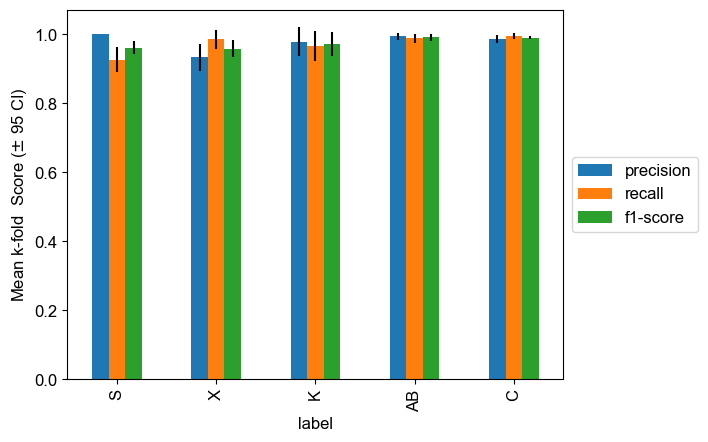

In [ ]:
#plon same plot

#get summary stats
d = clf_results.groupby(["label"])
means = d.mean()
ci = confInt(d, 1.96)

#sort order
idx = list(means['support'].sort_values().index)
idx = [i for i in idx if i in np.unique(labels.actual)]

means = means.loc[idx, ['precision', 'recall', 'f1-score']]
ci = ci.loc[idx, ['precision', 'recall', 'f1-score']]

means = means.loc[idx,:]
ci = ci.loc[idx,:]
# list(np.unique(labels['actual']))


means.plot.bar(yerr=ci)
#ax[i].set_yticks(np.linspace(0.90,1,6))
# plt.ylim(0.80-0.025, 1.025)

plt.ylabel(R'Mean k-fold  Score (${\pm}$ 95 CI)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(savepath / f"Test_metrics_per_class2.png")

**5.** Metrics that Penalizing Class imbalance

In [ ]:


print("Total cohen kappa=", round(cohen_kappa_score(labels.label, labels.actual),2))

print("Total matthews corrcoef=", round(matthews_corrcoef(labels.label, labels.actual),2))

labels
ck = []
mc = []

for k in np.arange(ksplit):

    d = labels[labels.kfold==k+1]

    # print(d)
    ck.append(cohen_kappa_score(d.label, d.actual))
    mc.append(matthews_corrcoef(d.label, d.actual))


Total cohen kappa= 0.98
Total matthews corrcoef= 0.98


In [ ]:
#get summaries

means = np.mean(ck)
std = np.std(ck)
ns = np.sqrt(len(ck))
ci = 1.96 * (std / ns)

print(f"mean kfold cohens kappa =  {round(means,2)} "+'\u00B1 '+f"{np.round(ci,3)}")



means = np.mean(mc)
std = np.std(mc)
ns = np.sqrt(len(mc))
ci = 1.96 * (std / ns)


print(f"mean kfold matthews corrcoef =  {round(means,2)} "+'\u00B1 '+f"{np.round(ci,3)}")

mean kfold cohens kappa =  0.98 ± 0.01
mean kfold matthews corrcoef =  0.98 ± 0.01


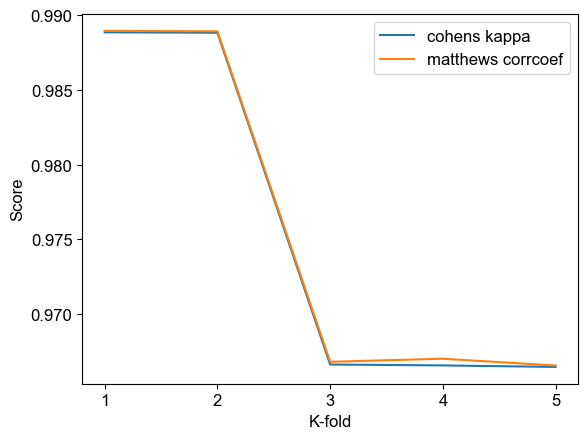

In [ ]:
#plot
plt.plot(np.arange(ksplit)+1, ck,label='cohens kappa')
plt.plot(np.arange(ksplit)+1, mc, label='matthews corrcoef')
plt.xlabel('K-fold')
plt.xticks(np.arange(ksplit)+1)
plt.ylabel('Score')
plt.legend()

### 6.5 Visualization

**1.** Calculate total K-fold confusion a matrix for test dataset

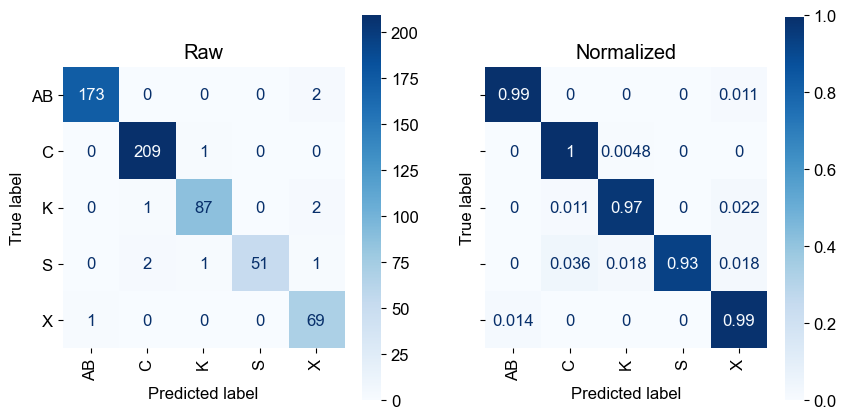

In [ ]:


def display_cmat(actual, predicted, ax, normalize=True, title=None):

  """ Display confusion matrix using sklearn's ConfusionMatrixDisplay

  Args:
    actual (list): list of actual labels
    predicted (list): list of predicted labels
    ax (matplotlib axis): axis to plot on
    normalize (bool): whether to normalize the confusion matrix or not
    title (str): title of the plot

  Returns:
    cmat (ConfusionMatrixDisplay object): ConfusionMatrixDisplay object

  """

  
  if normalize == True:
     cmat = ConfusionMatrixDisplay.from_predictions(actual, predicted, ax=ax, cmap='Blues', normalize='true')
  else:
     cmat = ConfusionMatrixDisplay.from_predictions(actual, predicted, ax=ax, cmap='Blues')


  # Remove the border (spines) of the colorbar
  cbar = cmat.im_.colorbar
  cbar.outline.set_visible(False)

  # Set tick labels
  ax.xaxis.set_ticklabels(np.unique(labels['actual']), rotation=90)
  ax.yaxis.set_ticklabels(np.unique(labels['actual']))
  # plt.title(f'Sum of kfolds')

  # Remove axis lines while keeping the ticks and labels
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)

  # Set title
  if title is None:
    if normalize == True:
      title = 'Normalized'
      cbar.set_ticks(np.linspace(0,1,6))
    else:
      title = 'Raw'

  ax.set_title(title)


  return cmat


fig, ax = plt.subplots(1,2, figsize=(10, 5), sharex=True, sharey=True)


display_cmat(labels['actual'], labels['label'], ax[0], normalize=False)
display_cmat(labels['actual'], labels['label'], ax[1], normalize=True)



**2.** Combine Validation and Test Confusion Matrices

Here we combine the confusion matrices in each k-fold for validation and testing. This is useful to see the overall performance of the model across all folds. 

First we summarize by summing the confusion matrices for each k-fold. Then we normalize the summed confusion matrix by dividing each value by the sum of the row. This gives us the proportion of correct predictions for each class. Second we show an alternative way to do this by taking the mean of each k-fold confusion matrix and then normalizing. Note that the normalized matrices for each will be the same as you are not adjusting the proportions in each row, only scaling them.

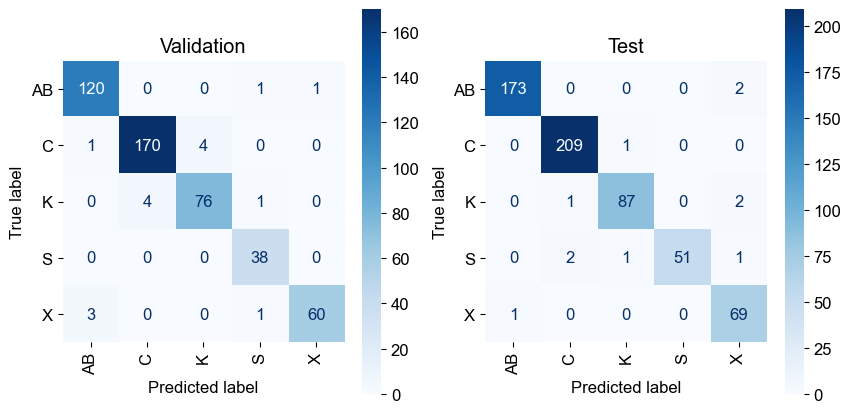

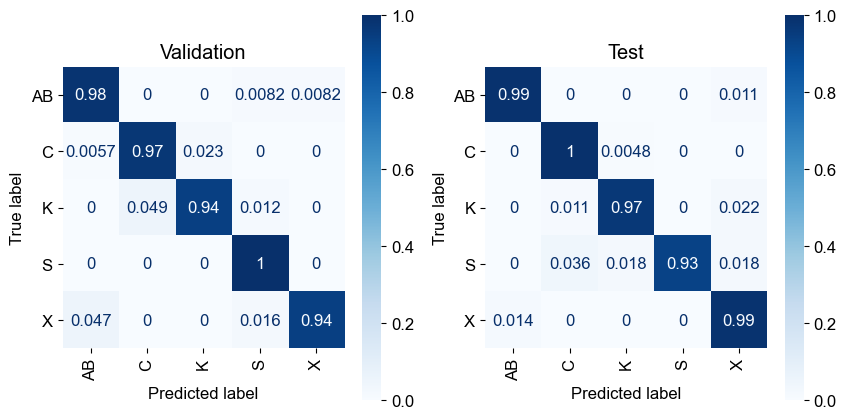

In [ ]:
#Sum + norm

# Set project path if missing
project_path = 'epoch_models'

#load in labels
best_labels_df = pd.read_csv(savepath / project_path /'best_labels.csv')

for normalize in [False, True]:

    # # Set font properties
    # plt.rcParams['font.family'] = 'Arial'  # Change to your preferred font
    # plt.rcParams['font.size'] = 12         # Adjust font size

    fig, ax = plt.subplots(1,2, figsize=(10, 5), sharex=True)

    cmat = []
    groups = best_labels_df.groupby('set')

    for name, group in groups:

            if name == 'val':

                if normalize == True:
                    cmat.append(ConfusionMatrixDisplay.from_predictions(group['actual'], group['label'], ax=ax[0], cmap='Blues', normalize='true'))
                else:
                    cmat.append(ConfusionMatrixDisplay.from_predictions(group['actual'], group['label'], ax=ax[0], cmap='Blues'))

                ax[0].xaxis.set_ticklabels(np.unique(group['actual']), rotation=90)
                ax[0].yaxis.set_ticklabels(np.unique(group['actual']))
                ax[0].set_title('Validation')

    if normalize == True:
        cmat.append(ConfusionMatrixDisplay.from_predictions(labels['actual'], labels['label'], ax=ax[1], cmap='Blues', normalize='true'))
    else: 
        cmat.append(ConfusionMatrixDisplay.from_predictions(labels['actual'], labels['label'], ax=ax[1], cmap='Blues'))

    ax[1].xaxis.set_ticklabels(np.unique(labels['actual']), rotation=90)
    ax[1].yaxis.set_ticklabels(np.unique(labels['actual']))
    ax[1].set_title('Test')

    for i in np.arange(2):

        # plt.title(f'Sum of kfolds')

        # Remove axis lines while keeping the ticks and labels
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['left'].set_visible(False)
        ax[i].spines['bottom'].set_visible(False)



        # Remove the border (spines) of the colorbar
        cbar = cmat[i].im_.colorbar
        cbar.outline.set_visible(False)

        if normalize == True:
            ax[i].images[0].set_clim(0, 1)
            if i ==1:
                cbar.set_ticks(np.linspace(0,1,6))

    
    
    plt.savefig(savepath / f"Val_Test_Confusion_Matrix_Summed_K-folds_Norm={normalize}.png")
    plt.savefig(savepath / f"Val_Test_Confusion_Matrix_Summed_K-folds_Norm={normalize}.eps")

Text(0.5, 0.98, 'Mean confusion matrix across k-folds')

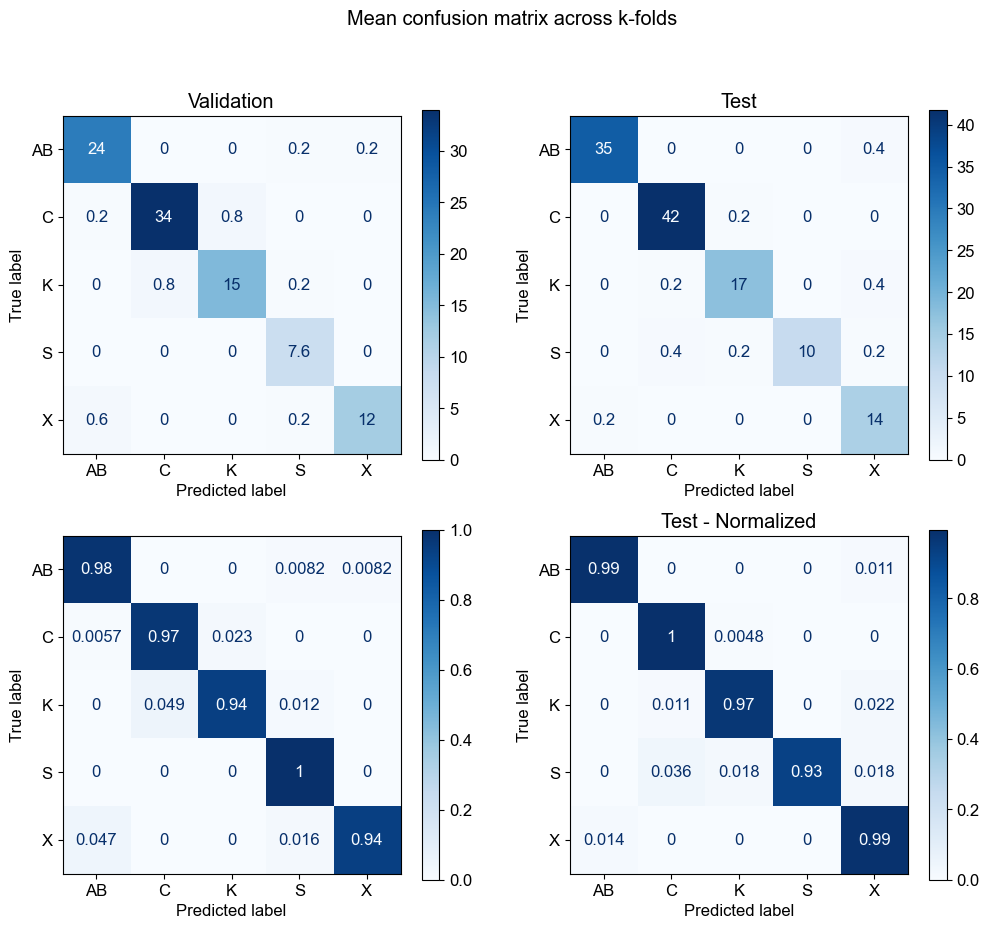

In [ ]:
# Means + norm 

# Derive class labels (assuming same classes across all folds and sets)
classes = sorted(np.unique(np.concatenate([
    best_labels_df['actual'].unique(), best_labels_df['label'].unique(),
    labels['actual'].unique(), labels['label'].unique()
])))


# Plot multiplot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))


test = best_labels_df[best_labels_df.set=='val']

groups = test.groupby('kfold')

# Initialize variables to store confusion matrices
conf_matrices = []

for name, group in groups:
    # Compute the confusion matrix for this fold
    cm = confusion_matrix(group['actual'], group['label'])
    
    # Store the confusion matrix
    conf_matrices.append(cm)

# Convert the list of confusion matrices into a numpy array and compute the mean
mean_cm = np.mean(conf_matrices, axis=0)

# # Display the mean confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=mean_cm, display_labels=classes)
disp.plot(ax=axes[0, 0], cmap='Blues')
axes[0, 0].set_title('Validation')


# Normalize the average confusion matrix (row-wise normalization)
mean_cm_normalized = mean_cm.astype('float') / mean_cm.sum(axis=1)[:, np.newaxis]

# # Display the mean confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=mean_cm_normalized, display_labels=classes)
disp.plot(ax=axes[1, 0], cmap='Blues')
axes[0, 1].set_title('Validation - Normalized')

groups = labels.groupby('kfold')

# Initialize variables to store confusion matrices
conf_matrices = []

for name, group in groups:
    # Compute the confusion matrix for this fold
    cm = confusion_matrix(group['actual'], group['label'])
    
    # Store the confusion matrix
    conf_matrices.append(cm)

# Convert the list of confusion matrices into a numpy array and compute the mean
mean_cm = np.mean(conf_matrices, axis=0)

# # Display the mean confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=mean_cm, display_labels=classes)
disp.plot(ax=axes[0, 1], cmap='Blues')
axes[0, 1].set_title('Test')

# Normalize the average confusion matrix (row-wise normalization)
mean_cm_normalized = mean_cm.astype('float') / mean_cm.sum(axis=1)[:, np.newaxis]

# # Display the mean confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=mean_cm_normalized, display_labels=classes)
disp.plot(ax=axes[1, 1], cmap='Blues')
axes[1, 1].set_title('Test - Normalized')

plt.suptitle('Mean confusion matrix across k-folds')

**3.** K-fold confusion matrices for test set

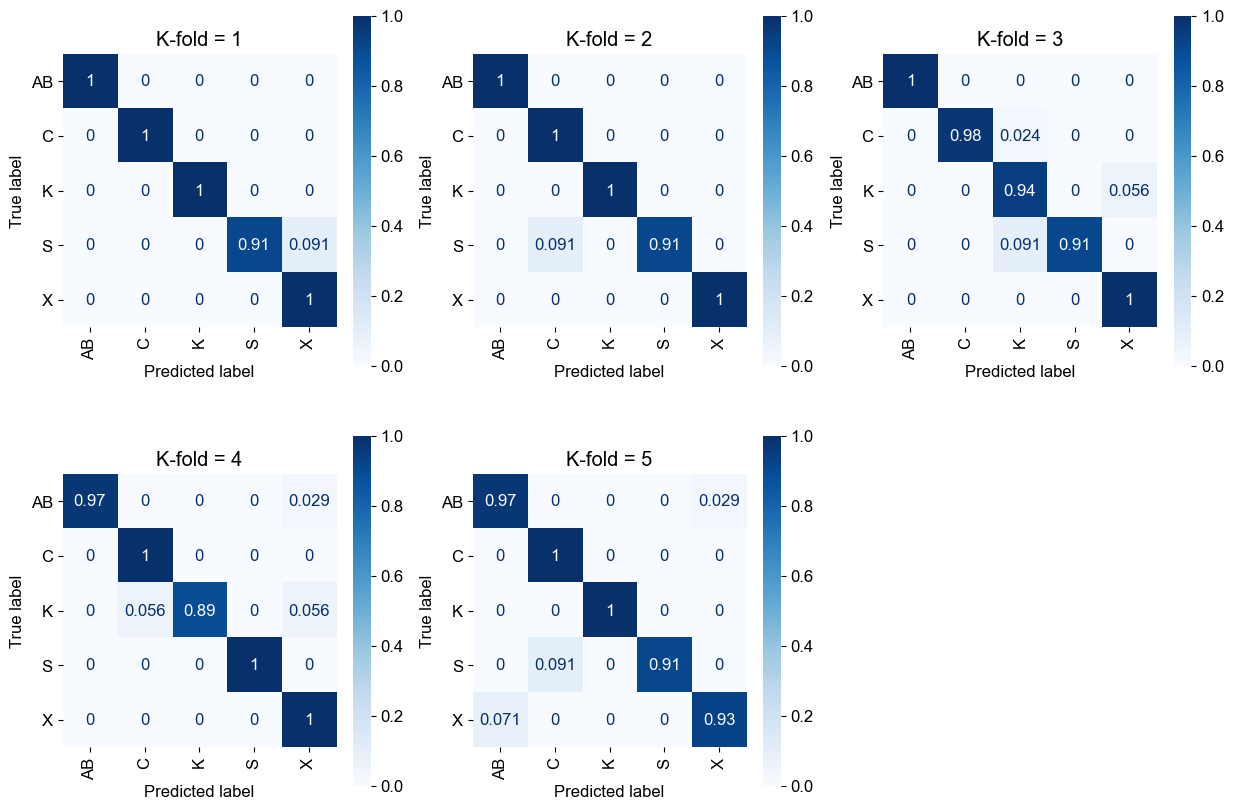

In [ ]:
#combined kfold plot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

groups = labels.groupby(['kfold'])
for group, ax in zip(groups, axes.flatten()):

    g = group[0]
    data = group[1]
    display_cmat(data['actual'], data['label'], ax, normalize=True, title=f"K-fold = {g[0]}")


# Remove empty axes
[fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data()]

plt.savefig(savepath / f"Test_Confusion_Matrix_K-fold_Multiplot.png")




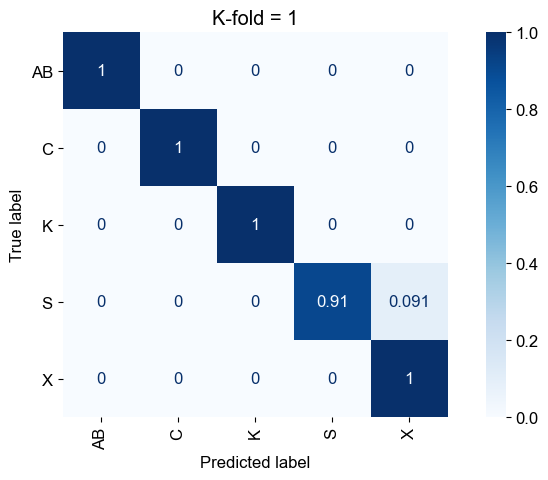

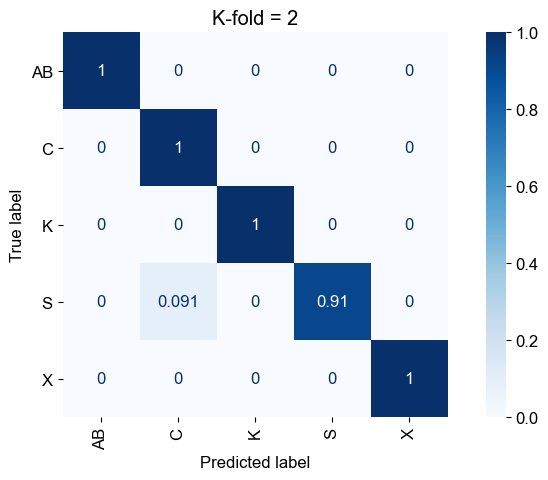

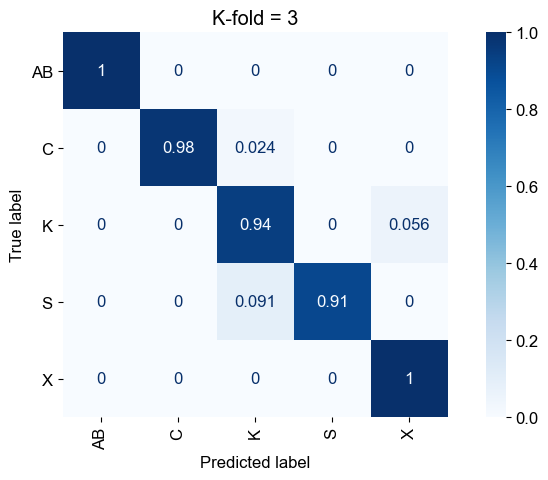

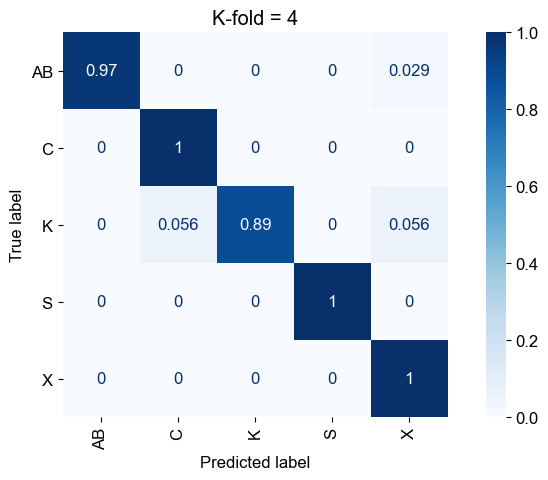

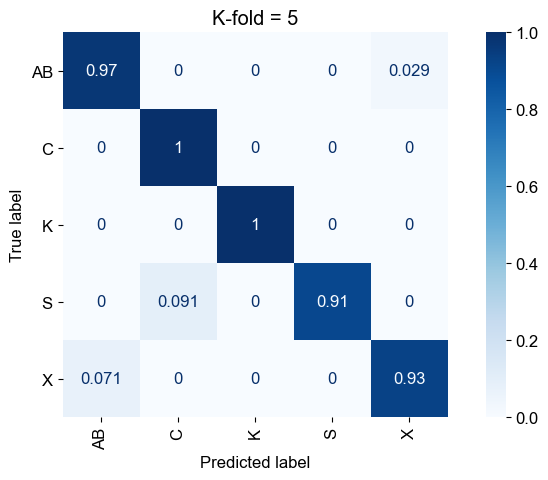

In [ ]:
#Alternative: separate plots for each kfold


groups = labels.groupby(['kfold'])
for group in groups:

    g = group[0]
    data = group[1]

    fig, ax = plt.subplots(figsize=(10, 5))
    display_cmat(data['actual'], data['label'], ax, normalize=True,title=f"K-fold = {g[0]}")

    plt.savefig(savepath / f"Test_Confusion_Matrix_K-fold={g[0]}.png")




**4.** Get wrong and right predictions in test set

In [ ]:
# get wrong and right predictions
wrong = labels[labels.label != labels.actual]
right = labels[labels.label == labels.actual]


#print
print("Wrong:")
print('mean confidence=', round(np.mean(wrong.score),2), '95ci=',round(confInt(wrong.score, 1.96),3))
print('mean confidence=', round(np.mean(wrong.score),2), 'stdev=',round(np.std(wrong.score),3))

print('\n')
print("mean number of errors per kfold= ", wrong.groupby('kfold').count().mean().iloc[0])
print('\n')

print("Right:")
print('mean confidence=', round(np.mean(right.score),2), '95ci=',round(confInt(right.score, 1.96),3))
print('mean confidence=', round(np.mean(right.score),2), 'stdev=',round(np.std(right.score),3))


Wrong:
mean confidence= 0.63 95ci= 0.078
mean confidence= 0.63 stdev= 0.125


mean number of errors per kfold=  2.2


Right:
mean confidence= 0.98 95ci= 0.005
mean confidence= 0.98 stdev= 0.059


**5.** Display images with predictions

> **Note:** This section displays the misclassified images and the associated confidence scores but can easily be adjusted to show the correct classifications.

In [ ]:


def display_images(data):

  """ Display images with their predicted and actual labels
  Args:
    data (pd.DataFrame): DataFrame containing image paths, predicted labels, and actual labels
  Returns:
    None. Function displays images and prints labels"""

  # print some info
  # print(f"Class: {data.actual.iloc[0]} Image: {os.path.basename(data.path.iloc[0])} ")
  temp_df = pd.DataFrame.from_dict({"True Class": [data.actual.iloc[0]], "Image": [os.path.basename(data.path.iloc[0])]}).T
  temp_df.columns = ['']
  display(temp_df)

  #plot image
  image_paths = list(data.path)

  temp_df2 = []

  #load image
  img = cv2.imread(data.path.iloc[0])  # Read image
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

  plt.imshow(img)
  plt.axis("off")
  plt.show()

  #get full prediction scores and print
  for i, img_path in enumerate(list(data.path)):

    #print some info on scores
    label = pd.read_csv(savepath / f"predict_{data.kfold.iloc[i]}" / 'labels' / data.image.iloc[i].replace('.png', '.txt'), header=None, sep=" ")

    #combine any class names with space in
    if len(label.columns) > 2:
        label.fillna('', inplace=True)
        label.loc[:, 1] = [" ".join([l for l in label.iloc[i, 1:]]) for i in np.arange(len(label))]
        label = label.loc[:, :1]

    score = ''

    for j in label.index:
        score += f" {label.iloc[j, 1]}: {label.iloc[j, 0]}"

    temp_df2.append([data.loc[i, 'kfold'], data.loc[i, 'label'], score])


  temp_df = pd.DataFrame(temp_df2, columns=["K-fold","Predicted", "Confidence Scores" ])
  # temp_df = pd.DataFrame.from_dict({"K-fold": [data.loc[i, 'kfold']], "Predicted (Top-score)": [data.loc[i, 'label']], "Scores": [score]}).T
  temp_df.index = temp_df["K-fold"]
  temp_df.drop("K-fold", axis=1, inplace=True)

  display(temp_df)




,
True Class,AB
Image,Cropped_ROV_19-2017_00251.png


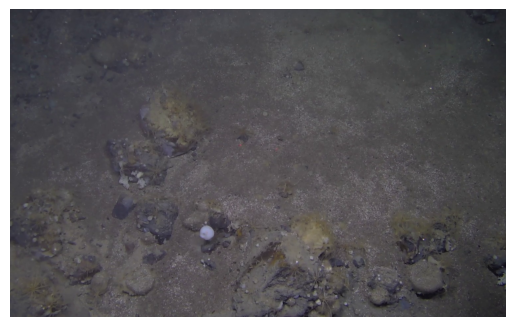

,Predicted,Confidence Scores
K-fold,,
4,X,X: 0.49 AB: 0.27 S: 0.2 C: 0.03 K: 0.01
5,X,X: 0.76 AB: 0.12 S: 0.1 C: 0.01 K: 0.01


,
True Class,C
Image,Cropped_ROV_17_00812.png


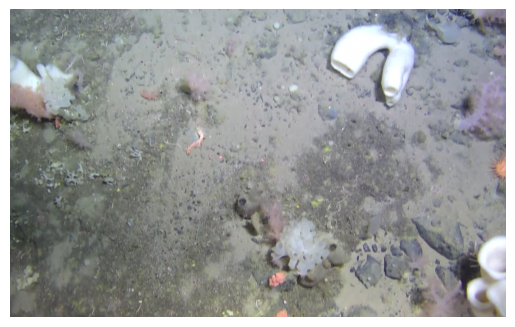

,Predicted,Confidence Scores
K-fold,,
3,K,K: 0.55 C: 0.42 AB: 0.02 X: 0.01 S: 0.01


,
True Class,K
Image,Cropped_ROV_17_00001.png


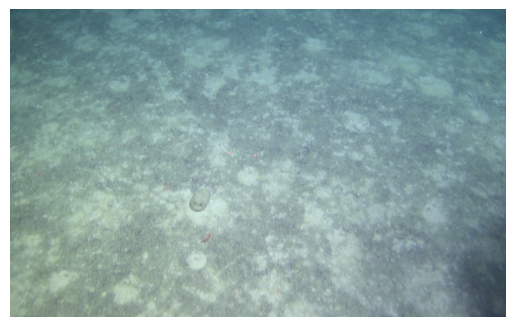

,Predicted,Confidence Scores
K-fold,,
3,X,X: 0.77 K: 0.18 C: 0.03 AB: 0.01 S: 0.0


,
True Class,K
Image,Cropped_ROV_17_00296.png


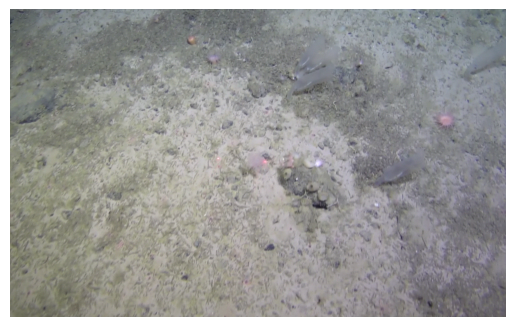

,Predicted,Confidence Scores
K-fold,,
4,C,C: 0.77 K: 0.11 AB: 0.06 S: 0.04 X: 0.02


,
True Class,K
Image,Cropped_ROV_17_00351.png


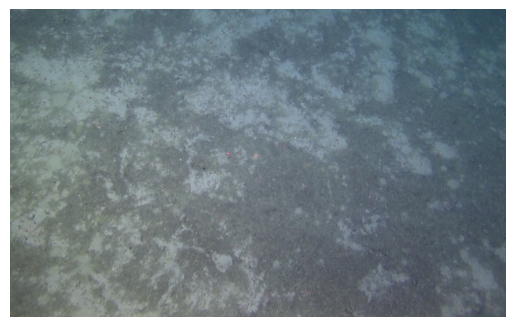

,Predicted,Confidence Scores
K-fold,,
4,X,X: 0.5 K: 0.5 C: 0.0 S: 0.0 AB: 0.0


,
True Class,S
Image,Cropped_ROV_22_00710.png


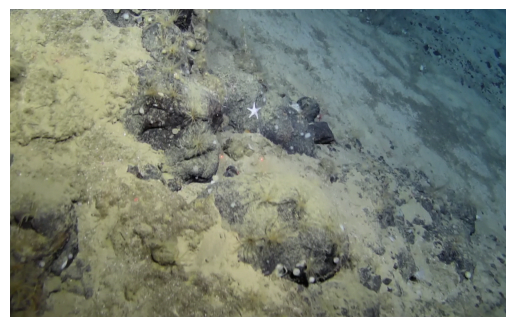

,Predicted,Confidence Scores
K-fold,,
1,X,X: 0.78 C: 0.11 S: 0.07 K: 0.04 AB: 0.0
2,C,C: 0.53 S: 0.2 X: 0.18 K: 0.06 AB: 0.03
3,K,K: 0.65 X: 0.19 C: 0.1 S: 0.06 AB: 0.0
5,C,C: 0.45 X: 0.34 S: 0.17 K: 0.04 AB: 0.0


,
True Class,X
Image,Cropped_ROV_19-2017_00357.png


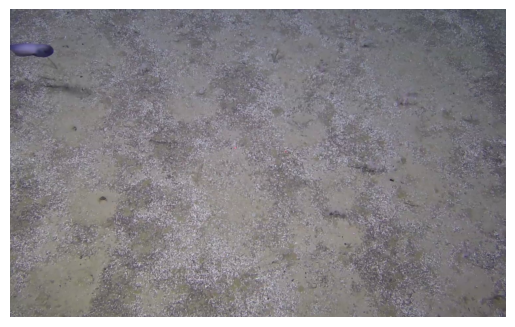

,Predicted,Confidence Scores
K-fold,,
5,AB,AB: 0.72 X: 0.28 K: 0.0 S: 0.0 C: 0.0


In [ ]:
# from matplotlib.image import imread
#look at image examples



#select some where model is confident and correct/ wrong and vise versa

groups= labels.sort_values(by='score').groupby('actual')

for cls, df in groups:
    
    #get wrong
    wrong = df[df.label != df.actual]
    wrong.reset_index(inplace=True, drop=True)

    #get right
    right = df[df.label == df.actual]
    right.reset_index(inplace=True, drop=True)


    # display(wrong)

    # right.to_csv('test.csv', sep=';')
    # print("WRONG PREDICTION")

    if len(wrong)>0:

        #sort by kfold
        wrong_groups = wrong.sort_values(by='kfold').groupby('path')

        for name, group in wrong_groups:

          group.reset_index(inplace=True, drop=True)

          display_images(group)

          print('\n')

    # if len(right)>0:

    #     print("RIGHT PREDICTION")

    #     right_groups = right.sort_values(by='kfold').groupby('path')

    #     for name, group in right_groups:

    #       group.reset_index(inplace=True, drop=True)

    #       display_images(group)

    #       print('\n')




**5.** View predictions on map

In [ ]:
#load all kfold predictions
labels = pd.read_csv(savepath / 'test_labels.csv')

#load original annotations
ann = pd.read_csv(f"{path}/Annotations.csv")


ann = ann.loc[:, ['IMAGE water', 'Latitude','Longitude','Cluster descr (Linktree Clusters)','Bathy depth [m]']]
ann.columns = ['image', 'latitude', 'longitude', 'actual', 'depth']

#set label as categorical

labels = labels.merge(ann, on=['image', 'actual'])
labels.label = labels.label.astype("category")
labels.rename(columns={"label": "predicted class"}, inplace=True)
labels

,image,score,class,predicted class,path,actual,kfold,latitude,longitude,depth
0,Cropped_ROV_12-2017_00006.png,0.90,0,AB,c:\Users\chloe\OneDrive - University of Bergen...,AB,1,73.7824,6.9062,2769.71
1,Cropped_ROV_12-2017_00029.png,1.00,0,AB,c:\Users\chloe\OneDrive - University of Bergen...,AB,1,73.7817,6.9098,2736.97
2,Cropped_ROV_12-2017_00037.png,1.00,0,AB,c:\Users\chloe\OneDrive - University of Bergen...,AB,1,73.7814,6.9110,2721.77
3,Cropped_ROV_12-2017_00039.png,1.00,0,AB,c:\Users\chloe\OneDrive - University of Bergen...,AB,1,73.7813,6.9112,2718.38
4,Cropped_ROV_12-2017_00066.png,1.00,0,AB,c:\Users\chloe\OneDrive - University of Bergen...,AB,1,73.7806,6.9154,2684.79
...,...,...,...,...,...,...,...,...,...,...
595,Cropped_ROV_22_00308.png,0.99,4,X,c:\Users\chloe\OneDrive - University of Bergen...,X,5,73.7709,7.0077,1630.43
596,Cropped_ROV_22_00570.png,1.00,4,X,c:\Users\chloe\OneDrive - University of Bergen...,X,5,73.7738,7.0373,1596.40
597,Cropped_ROV_22_00619.png,1.00,4,X,c:\Users\chloe\OneDrive - University of Bergen...,X,5,73.7736,7.0395,1572.09
598,Cropped_ROV_22_00708.png,1.00,4,X,c:\Users\chloe\OneDrive - University of Bergen...,X,5,73.7742,7.0461,1657.03


<Axes: xlabel='longitude', ylabel='latitude'>

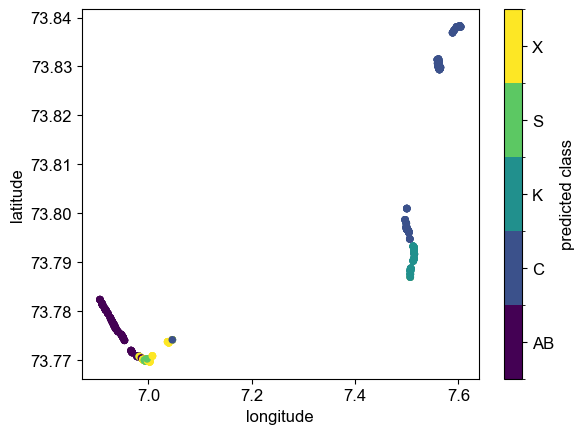

In [ ]:
labels.plot.scatter(x='longitude', y='latitude', c='predicted class', colormap='viridis')

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(go.Scattergeo())
fig.update_geos(projection_type="orthographic")
fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})

fig = px.scatter_geo(labels,
                    lat="latitude",
                    lon="longitude",                    
                    color = "predicted class",
                    hover_name="predicted class",
                    hover_data=["depth","actual"])

# fig.update_layout(title = 'World map', title_x=0.5)
fig.show()




<mark>**Next Step:**</mark> Proceed to [7. manual export from Colab](#manual-export-from-colab) to download the results from the Colab session. ***or*** skip to [8. Caveats of Google Colab](#caveats-of-google-colab) for some tips on using Colab.

## 7. Manual Export from Colab

Should you need to download files from Colab manually i.e. if there is a reason you cannot add the files to Google Drive. Note that by default this ignores the **data** folder and just downloads the **runs** folder with all the training and testing results. If you wish to export a different folder, ammend the path below. 

In [ ]:
# import ipywidgets as widgets
# from IPython.display import display

export_folder = f"/content/{project_name}/runs"

# Add text field for entering path to train.json
text_input = widgets.Text(value=export_folder, layout=widgets.Layout(width='50%'))

# Create a bold label if in fields_to_bold, otherwise normal text
label = widgets.HTML(f"<b>Export folder:</b>")

# Display UI
display(widgets.HBox([label, text_input]))

# Get default path
export_folder = text_input.value

# Create function to update project name
def update_folder(change):

    """Update the export_folder based on the text input. 
    
    Args:
        change: The change event from the text input widget.        

    Returns:
        str: The updated export_folder.
    """
    #define export_folder as global variable so it can be used elsewhere
    global export_folder

    # Update name to value from the text input widget
    export_folder = text_input.value

    return export_folder

# Update path
text_input.observe(update_folder, names='value')



In [ ]:
# from google.colab import drive, files
# import shutil

# #check if running in colab. Not relevant if running in jupyter notebook for example
if "google.colab" in sys.modules:

  #Make sure Google Drive is not mounted
  if not os.path.isdir('/content/drive'):

    print(f"Exporting {os.path.basename(export_folder)}.zip")

    #make zip file
    shutil.make_archive(os.path.basename(export_folder), 'zip', root_dir=export_folder)

    #download
    files.download(f"{os.path.basename(export_folder)}.zip")

    print("Finished!")

  else:
    print("Google drive mounted. Your files should be there.")
else:
  
  print("Not running in Colab. Your files should be saved locally.")

## 8. Troublehooting

### 8.1. General

> **Tip:** When encountering errors, you should not need to alter any code. Likely something has not run properly and a file/variable is missing or you have not got the correct paths. 


| Error    | Solution |
|----------|----------|
| Missing variables e.g. "base_path" is not defined"   | Re-run Sections [1](#prepare-computer-session-run-everytime) & [2](#3-load--prepare-data-run-everytime) where they are defined|
| Training Failed | Try again. Best to delete temporary image folder that was created to free up space | 
| Auto Download failed    | Try again later, else try the manual approach instead.   |
| Issues with image copying  | Try deleting the partial copies/folders with errors and starting again|
| Missing hyperparameters in [Section 3.1.2](#312-load--update)  | Maybe you have a partially downloaded train.json. Download again.|




### 8.2. Google Colab 


#### Caveats

- Speed is variable. Seems to be more demand in US working hours.
- Get booted out of session after a certain period of time. Due to:
  * Inactivity
  * Resource demands (i.e. number of users)
  * If you have been running it for a while.


  > **Tip** Free Colab is great for a test run, but for more serious usage it may be worth paying for Colab Pro to get access to more powerful GPUs and longer session times. 





| Error    | Solution |
|----------|----------|
| Session crashed  | Re-run Sections [1](#prepare-computer-session-run-everytime) & [2](#3-load--prepare-data-run-everytime) where they are defined|
| No GPUs available | Dont train models now. Focus on other tasks and try training again later| 





> **Tip:** If you are unsure of the errors, it might be worth starting the session again: i.e. re-running Sections [1](#prepare-computer-session-run-everytime) & [2](#3-load--prepare-data-run-everytime). If still getting errors, try **Runtime** > **Disconnect and Delete runtime** to reset the session to its original state and clear all variables. You will then need to re-run Sections [1](#prepare-computer-session-run-everytime) & [2](#3-load--prepare-data-run-everytime) again before continuing where you left off.


> **Note:** If you make an update to your Google Drive, there may be a short delay before the changes are reflected in Colab. 

## Optional: Download & run a trained model (Deployment/Inference)

From hugging face....
download model/weights, run on folder of images.